In [1]:
!pip install wfdb

# Kiểm tra phiên bản Python và các thư viện quan trọng
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import wfdb
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda if torch.cuda.is_available() else 'Notavailable'}")
print(f"GPU devices: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 3.3 MB/s eta 0:00:00a 0:00:01
Python version: 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
PyTorch version: 2.5.1+cu121
TensorFlow version: 2.17.1
NumPy version: 1.26.4
CUDA available: True
CUDA version: 12.1
GPU devices: Tesla T4


In [2]:
num_gpus = torch.cuda.device_count()
print("Số GPU có sẵn:", num_gpus)

Số GPU có sẵn: 2


In [4]:
import os

# Đường dẫn đến thư mục dữ liệu trong dataset Kaggle
bidmc_data_path = r'/kaggle/input/bidmc-capno-datasets/bidmc'

# Thư mục train_folder nằm trong thư mục làm việc của Kaggle Notebook
train_folder = "train_folder"
train_path = os.path.join(r'/kaggle/working/', train_folder)
os.makedirs(train_path, exist_ok=True)


In [5]:
def check_gpu_status():
    if torch.cuda.is_available():
        print(f"GPU đang sử dụng: {torch.cuda.get_device_name(0)}")
        print("Số GPU có sẵn:", torch.cuda.device_count())
        print(f"Bộ nhớ GPU được cấp phát:{torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
        print(f"Bộ nhớ GPU dành riêng: {torch.cuda.memory_reserved(0)/1024**2:.2f}MB")
    else:
        print("Không có GPU khả dụng. Sử dụng CPU.")
def set_seed(seed=42):
    """Đặt giá trị seed cho tính tái lập"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # Nếu sử dụng nhiều GPU
    tf.random.set_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Đã thiết lập seed = {seed}")
# Thiết lập để tái lập kết quả
set_seed()
check_gpu_status()

Đã thiết lập seed = 42
GPU đang sử dụng: Tesla T4
Số GPU có sẵn: 2
Bộ nhớ GPU được cấp phát:0.00 MB
Bộ nhớ GPU dành riêng: 0.00MB


Danh sách các file BMDIC:
['bidmc08.breath', 'bidmc52.breath', 'bidmc17n.hea', 'bidmc44n.dat', 'bidmc31.dat', 'bidmc51.dat', 'bidmc33n.hea', 'bidmc21.hea', 'bidmc37n.hea', 'bidmc34n.dat', 'bidmc53n.dat', 'bidmc18.dat', 'bidmc20.breath', 'bidmc25.dat', 'bidmc04n.dat', 'bidmc08.hea', 'bidmc53.breath', 'ANNOTATORS', 'bidmc28.hea', 'bidmc51n.dat', 'bidmc44n.hea', 'bidmc45n.dat', 'bidmc26n.hea', 'bidmc22n.hea', 'SHA256SUMS.txt', 'bidmc47.dat', 'bidmc39.breath', 'bidmc23.breath', 'bidmc03n.dat', 'bidmc49n.dat', 'bidmc07n.dat', 'bidmc25n.hea', 'bidmc33.hea', 'bidmc32.breath', 'bidmc36.dat', 'bidmc06n.hea', 'bidmc48.hea', 'bidmc35.dat', 'bidmc53.hea', 'bidmc44.dat', 'bidmc30.breath', 'bidmc36.hea', 'bidmc30n.dat', 'bidmc53n.hea', 'bidmc10.hea', 'bidmc25.breath', 'bidmc40n.dat', 'bidmc46n.dat', 'bidmc31n.hea', 'bidmc09.breath', 'bidmc26n.dat', 'bidmc16.dat', 'bidmc35n.dat', 'bidmc19n.hea', 'bidmc34n.hea', 'bidmc08.dat', 'bidmc22.hea', 'bidmc05.hea', 'LICENSE', 'bidmc25.hea', 'bidmc45n.hea', 'bi

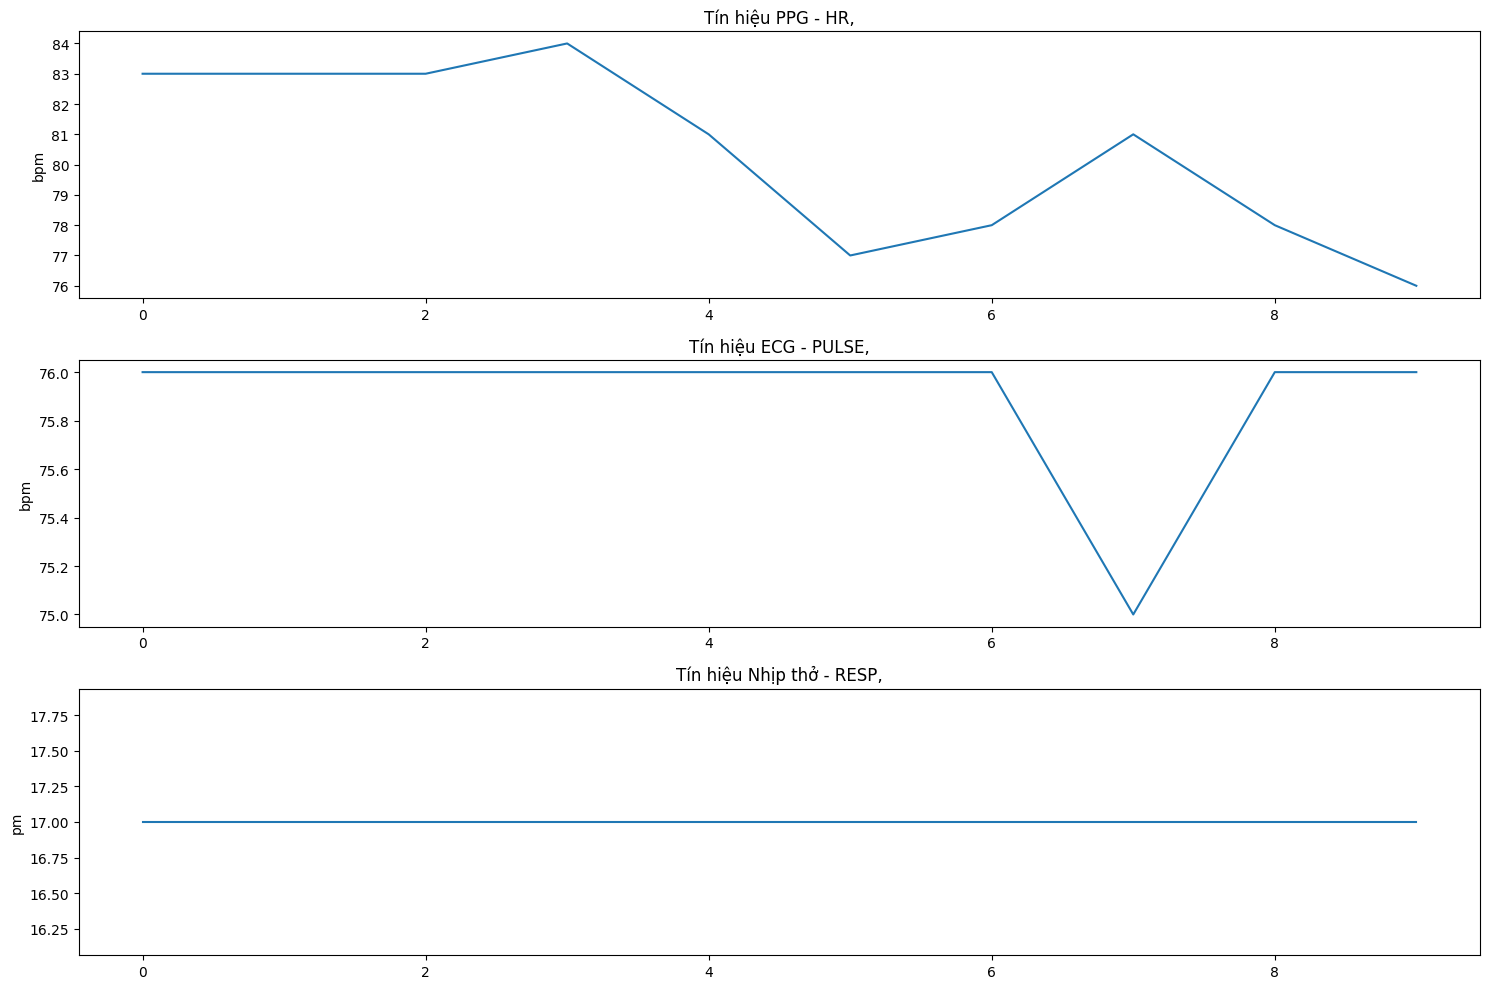

In [6]:
def explore_bidmc_dataset():
# Liệt kê các file trong thư mục dữ liệu
    print("Danh sách các file BMDIC:")
    print(os.listdir(bidmc_data_path))
    sample_file = None
    files = os.listdir(bidmc_data_path)
    for file in files:
        if file.endswith('.dat') or file.endswith('.hea'):
            sample_file = os.path.join(bidmc_data_path,os.path.splitext(file)[0])
            break
    if sample_file:
        try:
            # Đọc dữ liệu
            record = wfdb.rdrecord(sample_file)
            print(f"\nThông tin file mẫu BMDIC:")
            print(f"Tần số lấy mẫu: {record.fs} Hz")
            print(f"Số lượng kênh: {record.n_sig}")
            print(f"Tên các kênh: {record.sig_name}")
            print(f"Số lượng mẫu: {record.sig_len}")
            print(f"Đơn vị: {record.units}")
            # Hiển thị
            plt.figure(figsize=(15, 10))
            # Xác định số lượng kênh cần hiển thị
            n_channels = min(3, record.n_sig) # Hiển thị tối đa 3 kênh
            # Tìm vị trí của các kênh quan trọng
            ppg_idx = next((i for i, name in enumerate(record.sig_name) if 'ppg' in name.lower()), 0)
            ecg_idx = next((i for i, name in enumerate(record.sig_name) if 'ecg' in name.lower()), 1 % record.n_sig)
            resp_idx = next((i for i, name in enumerate(record.sig_name) if 'resp' in name.lower() or 'breath' in name.lower()), 2 % record.n_sig)
            # Hiển thị 10 giây đầu tiên
            seconds_to_show = 10
            samples_to_show = int(seconds_to_show * record.fs)
            # Hiển thị từng kênh
            plt.subplot(n_channels, 1, 1)
            plt.plot(record.p_signal[:samples_to_show, ppg_idx])
            plt.title(f"Tín hiệu PPG - {record.sig_name[ppg_idx]}")
            plt.ylabel(record.units[ppg_idx])
            plt.subplot(n_channels, 1, 2)
            plt.plot(record.p_signal[:samples_to_show, ecg_idx])
            plt.title(f"Tín hiệu ECG - {record.sig_name[ecg_idx]}")
            plt.ylabel(record.units[ecg_idx])
            if n_channels > 2:
                plt.subplot(n_channels, 1, 3)
                plt.plot(record.p_signal[:samples_to_show, resp_idx])
                plt.title(f"Tín hiệu Nhịp thở - {record.sig_name[resp_idx]}")
                plt.ylabel(record.units[resp_idx])
            plt.tight_layout()
            plt.show()
            return record
        except Exception as e:
            print(f"Đọc file bị lỗi. {e}")
        else:
            print("Không tìm thấy file mẫu với định dạng hỗ trợ trong thư mục BIDMC")

explore_bidmc_dataset()

In [7]:
ieee_data_path = r"/kaggle/input/bidmc-capno-datasets/capno/data/mat"

📂 Danh sách các file Capno IEEE:
  - 0105_8min.mat
  - 0030_8min.mat
  - 0028_8min.mat
  - 0313_8min.mat
  - 0015_8min.mat
  - 0147_8min.mat
  - 0370_8min.mat
  - 0035_8min.mat
  - 0148_8min.mat
  - 0150_8min.mat
  - 0330_8min.mat
  - 0325_8min.mat
  - 0032_8min.mat
  - 0133_8min.mat
  - 0038_8min.mat
  - 0127_8min.mat
  - 0115_8min.mat
  - 0123_8min.mat
  - 0023_8min.mat
  - 0149_8min.mat
  - 0103_8min.mat
  - 0104_8min.mat
  - 0312_8min.mat
  - 0018_8min.mat
  - 0128_8min.mat
  - 0134_8min.mat
  - 0029_8min.mat
  - 0121_8min.mat
  - 0122_8min.mat
  - 0322_8min.mat
  - 0328_8min.mat
  - 0009_8min.mat
  - 0125_8min.mat
  - 0031_8min.mat
  - 0329_8min.mat
  - 0016_8min.mat
  - 0142_8min.mat
  - 0311_8min.mat
  - 0331_8min.mat
  - 0333_8min.mat
  - 0332_8min.mat
  - 0309_8min.mat

📜 Thông tin file mẫu: 0105_8min.mat
🔑 Các khóa chính: ['#refs#', 'SFresults', 'labels', 'meta', 'param', 'reference', 'signal']
✅ Extracted 'co2/y' data: shape (144001,), dtype float64
✅ Extracted 'ecg/y' data:

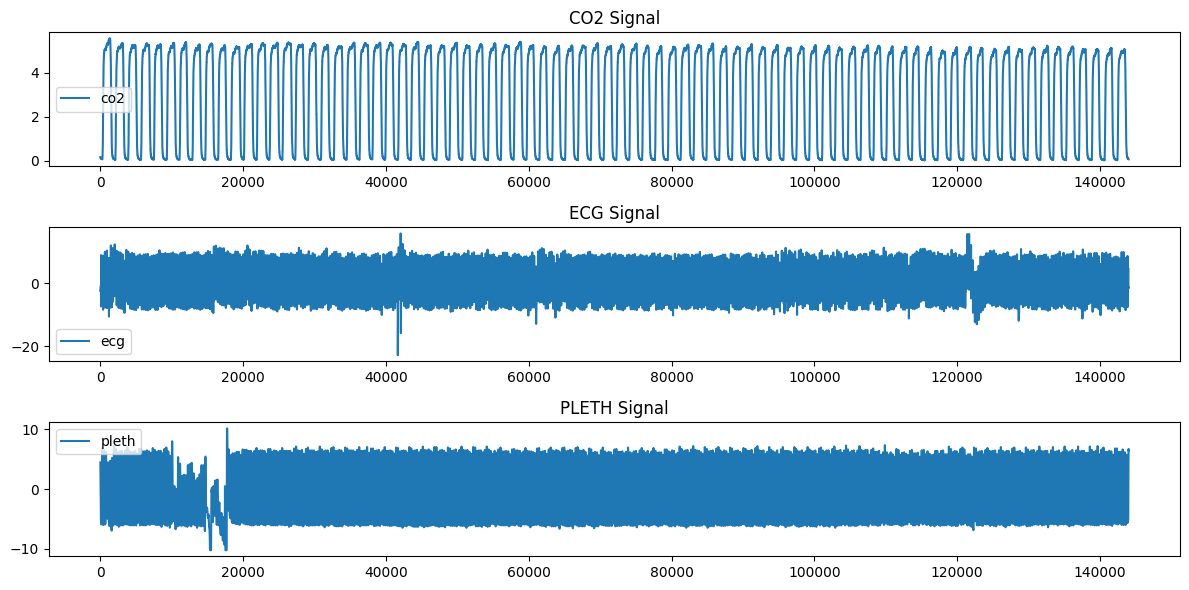

{'co2': array([0.16, 0.16, 0.16, ..., 0.06, 0.06, 0.06]),
 'ecg': array([-2.43, -2.43, -2.43, ..., -1.49, -1.52, -1.54]),
 'pleth': array([4.48, 4.32, 4.16, ..., 6.64, 6.56, 6.48])}

In [8]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

def explore_capno_dataset():
    """Khám phá và hiển thị thông tin cơ bản về bộ dữ liệu Capno IEEE (MATLAB v7.3 - HDF5)"""

    # Liệt kê các file trong thư mục dữ liệu
    print("📂 Danh sách các file Capno IEEE:")
    files = [f for f in os.listdir(ieee_data_path) if f.endswith('.mat')]
    if not files:
        print("❌ Không tìm thấy file .mat nào trong thư mục!")
        return None

    for file in files:
        print(f"  - {file}")

    # Lấy file mẫu đầu tiên
    sample_file = os.path.join(ieee_data_path, files[0])

    try:
        # Đọc file .mat sử dụng h5py
        with h5py.File(sample_file, "r") as mat_file:
            print(f"\n📜 Thông tin file mẫu: {os.path.basename(sample_file)}")
            print(f"🔑 Các khóa chính: {list(mat_file.keys())}")

            # Kiểm tra nhóm "signal"
            if "signal" not in mat_file:
                print("❌ Không tìm thấy nhóm 'signal' trong file!")
                return None

            signal_group = mat_file["signal"]
            signals = {}

            # Lặp qua các tín hiệu (co2, ecg, pleth)
            for key in signal_group.keys():
                sub_group = signal_group[key]  # Access 'co2', 'ecg', 'pleth'

                if isinstance(sub_group, h5py.Group) and "y" in sub_group:
                    data = np.array(sub_group["y"]).flatten()  # Flatten to 1D array
                    signals[key] = data
                    print(f"✅ Extracted '{key}/y' data: shape {data.shape}, dtype {data.dtype}")

            # 📊 Hiển thị tín hiệu
            if not signals:
                print("❌ Không có tín hiệu nào được trích xuất!")
                return None

            plt.figure(figsize=(12, 6))
            for i, (key, data) in enumerate(signals.items(), start=1):
                plt.subplot(len(signals), 1, i)
                plt.plot(data, label=key)
                plt.title(f"{key.upper()} Signal")
                plt.legend()

            plt.tight_layout()
            plt.show()

            return signals

    except Exception as e:
        print(f"❌ Lỗi khi đọc file Capno IEEE: {e}")
        return None
explore_capno_dataset()

In [9]:
def prepare_combined_dataset(bidmc_path, capno_path, save_path):
    import wfdb
    import scipy.io
    import numpy as np
    import os
    import h5py
    from tqdm import tqdm

    # Tạo thư mục lưu trữ nếu chưa tồn tại
    os.makedirs(save_path, exist_ok=True)


    # Danh sách để lưu dữ liệu từ cả hai bộ
    ppg_segments = []
    ecg_segments = []
    resp_segments = []

    # Lấy danh sách các file có đuôi .dat hoặc .hea
    bidmc_files = [f for f in os.listdir(bidmc_path) if f.endswith('.dat') or f.endswith('.hea')]
    bidmc_record_names = set(os.path.splitext(f)[0] for f in bidmc_files)

    for record_name in tqdm(bidmc_record_names):
        try:
            record_path = os.path.join(bidmc_path, record_name)
            record = wfdb.rdrecord(record_path)

            # Tìm vị trí của các kênh quan trọng
            ppg_idx = next((i for i, name in enumerate(record.sig_name) if 'ppg' in name.lower()), None)
            ecg_idx = next((i for i, name in enumerate(record.sig_name) if 'ecg' in name.lower()), None)
            resp_idx = next((i for i, name in enumerate(record.sig_name) if 'resp' in name.lower() or 'breath' in name.lower()), None)

            # Kiểm tra xem có đủ 3 kênh cần thiết không
            if ppg_idx is not None and ecg_idx is not None and resp_idx is not None:
                # Trích xuất tín hiệu
                ppg_signal = record.p_signal[:, ppg_idx]
                ecg_signal = record.p_signal[:, ecg_idx]
                resp_signal = record.p_signal[:, resp_idx]

                # Phân đoạn tín hiệu thành các cửa sổ 10 giây
                window_size = int(10 * record.fs)  # 10 giây
                stride = int(5 * record.fs)  # 5 giây (chồng lấp 50%)

                for i in range(0, len(ppg_signal) - window_size, stride):
                    ppg_window = ppg_signal[i:i + window_size]
                    ecg_window = ecg_signal[i:i + window_size]
                    resp_window = resp_signal[i:i + window_size]

                    # Kiểm tra chất lượng đoạn tín hiệu (không có nhiều giá trị 0 liên tiếp)
                    if (np.count_nonzero(ppg_window) > 0.8 * window_size and
                        np.count_nonzero(ecg_window) > 0.8 * window_size and
                        np.count_nonzero(resp_window) > 0.8 * window_size):

                        # Thêm vào danh sách
                        ppg_segments.append(ppg_window)
                        ecg_segments.append(ecg_window)
                        resp_segments.append(resp_window)

        except Exception as e:
            print(f"Lỗi khi xử lý file BIDMC {record_name}: {e}")

    # Xử lý dữ liệu Capno IEEE
    print("\nĐang xử lý dữ liệu Capno IEEE...")
    capno_files = [f for f in os.listdir(capno_path) if f.endswith('.mat')]
    for file_name in tqdm(capno_files):
        try:
            file_path = os.path.join(capno_path, file_name)
            with h5py.File(file_path, "r") as mat_file:

                # Kiểm tra nhóm "signal"
                if "signal" not in mat_file:
                    continue

                signal_group = mat_file["signal"]
                signals = {}

                # Lặp qua các tín hiệu (co2, ecg, pleth)
                for key in signal_group.keys():
                    sub_group = signal_group[key]  # Access 'co2', 'ecg', 'pleth'

                    if isinstance(sub_group, h5py.Group) and "y" in sub_group:
                        data = np.array(sub_group["y"]).flatten()  # Flatten to 1D array
                        signals[key] = data

                if "co2" in signals and "ecg" in signals and "pleth" in signals:
                    co2_signal = signals["co2"]
                    ecg_signal = signals["ecg"]
                    ppg_signal = signals["pleth"]

                    min_length = min(len(ppg_signal), len(ecg_signal), len(co2_signal))
                    ppg_signal = ppg_signal[:min_length]
                    ecg_signal = ecg_signal[:min_length]
                    co2_signal = co2_signal[:min_length]

                    fs = 100  # Giả sử tần số lấy mẫu là 100 Hz
                    window_size = int(10 * fs)  # 10 giây
                    stride = int(5 * fs)  # 5 giây (chồng lấp 50%)

                    for i in range(0, min_length - window_size, stride):
                        ppg_window = ppg_signal[i:i + window_size]
                        ecg_window = ecg_signal[i:i + window_size]
                        co2_window = co2_signal[i:i + window_size]

                        if (np.count_nonzero(ppg_window) > 0.8 * window_size and
                            np.count_nonzero(ecg_window) > 0.8 * window_size and
                            np.count_nonzero(co2_window) > 0.8 * window_size):
                            ppg_segments.append(ppg_window)
                            ecg_segments.append(ecg_window)
                            resp_segments.append(co2_window)  # Sử dụng CO2 làm nhịp thở

        except Exception as e:
            print(f"Lỗi khi xử lý file Capno IEEE {file_name}: {e}")
    # Chuyển đổi các danh sách thành mảng numpy
    ppg_data = np.array(ppg_segments)
    ecg_data = np.array(ecg_segments)
    resp_data = np.array(resp_segments)
    print(f"\nTổng số phân đoạn dữ liệu: {len(ppg_segments)}")
    print(f"Kích thước dữ liệu PPG: {ppg_data.shape}")
    print(f"Kích thước dữ liệu ECG: {ecg_data.shape}")
    print(f"Kích thước dữ liệu nhịp thở: {resp_data.shape}")
    # Lưu dữ liệu đã xử lý
    output_file = os.path.join(save_path, 'combined_dataset.npz')
    np.savez_compressed(
    output_file,
    ppg=ppg_data,
    ecg=ecg_data,
    resp=resp_data
    )
    print(f"Đã lưu dữ liệu kết hợp tại: {output_file}")
    return output_file
#Kết hợp
combined_data_path = prepare_combined_dataset(bidmc_data_path, ieee_data_path, train_path)


100%|██████████| 106/106 [00:02<00:00, 51.05it/s]



Đang xử lý dữ liệu Capno IEEE...


100%|██████████| 42/42 [00:02<00:00, 20.37it/s]



Tổng số phân đoạn dữ liệu: 11979
Kích thước dữ liệu PPG: (11979, 1000)
Kích thước dữ liệu ECG: (11979, 1000)
Kích thước dữ liệu nhịp thở: (11979, 1000)
Đã lưu dữ liệu kết hợp tại: /kaggle/working/train_folder/combined_dataset.npz


In [10]:

def split_dataset(data_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Phân chia dữ liệu thành tập huấn luyện, xác thực và kiểm tra.

    Tham số:
    - data_path: Đường dẫn đến file dữ liệu đã xử lý (.npz)
    - train_ratio, val_ratio, test_ratio: Tỷ lệ phân chia

    Trả về:
    - Đường dẫn đến các file đã phân chia
    """
    import numpy as np
    import os
    from sklearn.model_selection import train_test_split
    # Kiểm tra tổng tỷ lệ hợp lệ
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Tổng các tỷ lệ phải bằng 1"

    # Tạo thư mục đầu ra
    output_dir = os.path.dirname(data_path)

    # Đọc dữ liệu
    data = np.load(data_path)
    ppg = data['ppg']
    ecg = data['ecg']
    resp = data['resp']

    # Phân chia train và temp (val + test)
    ppg_train, ppg_temp, ecg_train, ecg_temp, resp_train, resp_temp = train_test_split(
        ppg, ecg, resp, train_size=train_ratio, random_state=42
    )

    # Phân chia temp thành val và test
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    ppg_val, ppg_test, ecg_val, ecg_test, resp_val, resp_test = train_test_split(
        ppg_temp, ecg_temp, resp_temp, train_size=val_ratio_adjusted, random_state=42
    )

    # In thông tin
    print("Kích thước các tập dữ liệu:")
    print(f"Tập huấn luyện: {len(ppg_train)} mẫu")
    print(f"Tập xác thực: {len(ppg_val)} mẫu")
    print(f"Tập kiểm tra: {len(ppg_test)} mẫu")

    # Lưu các tập dữ liệu
    train_path = os.path.join(output_dir, 'train_data.npz')
    val_path = os.path.join(output_dir, 'val_data.npz')
    test_path = os.path.join(output_dir, 'test_data.npz')

    np.savez_compressed(train_path, ppg=ppg_train, ecg=ecg_train, resp=resp_train)
    np.savez_compressed(val_path, ppg=ppg_val, ecg=ecg_val, resp=resp_val)
    np.savez_compressed(test_path, ppg=ppg_test, ecg=ecg_test, resp=resp_test)

    print(f"Đã lưu tập huấn luyện tại: {train_path}")
    print(f"Đã lưu tập xác thực tại: {val_path}")
    print(f"Đã lưu tập kiểm tra tại: {test_path}")

    return train_path, val_path, test_path

# Phân chia dữ liệu
train_path, val_path, test_path = split_dataset(combined_data_path)


Kích thước các tập dữ liệu:
Tập huấn luyện: 8385 mẫu
Tập xác thực: 1797 mẫu
Tập kiểm tra: 1797 mẫu
Đã lưu tập huấn luyện tại: /kaggle/working/train_folder/train_data.npz
Đã lưu tập xác thực tại: /kaggle/working/train_folder/val_data.npz
Đã lưu tập kiểm tra tại: /kaggle/working/train_folder/test_data.npz


In [11]:
import numpy as np
import os
from tqdm import tqdm
from scipy import signal as scipy_signal

def standardize_sampling_rate(signal, original_fs, target_fs=250):
    """
    Chuẩn hóa tần số lấy mẫu của tín hiệu.

    Tham số:
    - signal: Mảng numpy chứa tín hiệu
    - original_fs: Tần số lấy mẫu gốc (Hz)
    - target_fs: Tần số lấy mẫu mục tiêu (Hz)

    Trả về:
    - Tín hiệu đã chuẩn hóa tần số lấy mẫu
    """



    # Nếu tần số lấy mẫu đã đúng, không cần xử lý
    if original_fs == target_fs:
        return signal

    # Tính toán số lượng mẫu mới
    orig_len = len(signal)
    new_len = int(orig_len * (target_fs / original_fs))

    # Resample tín hiệu
    resampled_signal = scipy_signal.resample(signal, new_len)

    return resampled_signal


def standardize_dataset_sampling_rate(data_path, bidmc_fs=250, capno_fs=100, target_fs=250):
    """
    Chuẩn hóa tần số lấy mẫu cho toàn bộ bộ dữ liệu.

    Tham số:
    - data_path: Đường dẫn đến file dữ liệu
    - bidmc_fs: Tần số lấy mẫu của dữ liệu BIDMC
    - capno_fs: Tần số lấy mẫu của dữ liệu Capno
    - target_fs: Tần số lấy mẫu mục tiêu

    Trả về:
    - Đường dẫn đến file dữ liệu đã chuẩn hóa
    """
    # Đọc dữ liệu
    data = np.load(data_path)
    ppg = data['ppg']
    ecg = data['ecg']
    resp = data['resp']

    # Xác định xem tín hiệu có phải từ Capno hay không dựa vào độ dài
    # Giả sử tín hiệu từ BIDMC có độ dài = 10s * 250Hz = 2500 mẫu
    # Giả sử tín hiệu từ Capno có độ dài = 10s * 100Hz = 1000 mẫu
    window_size_bidmc = 10 * bidmc_fs
    window_size_capno = 10 * capno_fs

    # Chuẩn hóa từng phân đoạn
    ppg_resampled = []
    ecg_resampled = []
    resp_resampled = []

    for i in tqdm(range(len(ppg)), desc="Chuẩn hóa tần số lấy mẫu"):
        # Xác định tần số gốc dựa vào độ dài
        orig_len = len(ppg[i])
        original_fs = bidmc_fs if abs(orig_len - window_size_bidmc) < abs(orig_len - window_size_capno) else capno_fs

        # Chuẩn hóa từng tín hiệu
        ppg_resampled.append(standardize_sampling_rate(ppg[i], original_fs, target_fs))
        ecg_resampled.append(standardize_sampling_rate(ecg[i], original_fs, target_fs))
        resp_resampled.append(standardize_sampling_rate(resp[i], original_fs, target_fs))

    # Chuyển đổi thành mảng numpy
    ppg_resampled = np.array(ppg_resampled)
    ecg_resampled = np.array(ecg_resampled)
    resp_resampled = np.array(resp_resampled)

    # In thông tin
    print(f"Kích thước dữ liệu sau khi chuẩn hóa:")
    print(f"PPG: {ppg_resampled.shape}")
    print(f"ECG: {ecg_resampled.shape}")
    print(f"Nhịp thở: {resp_resampled.shape}")

    # Lưu dữ liệu đã chuẩn hóa
    output_dir = os.path.dirname(data_path)
    output_file = os.path.join(output_dir, os.path.basename(data_path).replace('.npz', '_standardized.npz'))

    np.savez_compressed(output_file, ppg=ppg_resampled, ecg=ecg_resampled, resp=resp_resampled)

    print(f"Đã lưu dữ liệu chuẩn hóa tại: {output_file}")
    return output_file


# Chuẩn hóa tần số lấy mẫu cho từng tập dữ liệu
train_std_path = standardize_dataset_sampling_rate(train_path)
val_std_path = standardize_dataset_sampling_rate(val_path)
test_std_path = standardize_dataset_sampling_rate(test_path)


Chuẩn hóa tần số lấy mẫu: 100%|██████████| 8385/8385 [00:01<00:00, 4290.37it/s]


Kích thước dữ liệu sau khi chuẩn hóa:
PPG: (8385, 2500)
ECG: (8385, 2500)
Nhịp thở: (8385, 2500)
Đã lưu dữ liệu chuẩn hóa tại: /kaggle/working/train_folder/train_data_standardized.npz


Chuẩn hóa tần số lấy mẫu: 100%|██████████| 1797/1797 [00:00<00:00, 5274.22it/s]


Kích thước dữ liệu sau khi chuẩn hóa:
PPG: (1797, 2500)
ECG: (1797, 2500)
Nhịp thở: (1797, 2500)
Đã lưu dữ liệu chuẩn hóa tại: /kaggle/working/train_folder/val_data_standardized.npz


Chuẩn hóa tần số lấy mẫu: 100%|██████████| 1797/1797 [00:00<00:00, 5555.03it/s]


Kích thước dữ liệu sau khi chuẩn hóa:
PPG: (1797, 2500)
ECG: (1797, 2500)
Nhịp thở: (1797, 2500)
Đã lưu dữ liệu chuẩn hóa tại: /kaggle/working/train_folder/test_data_standardized.npz


Loaded original sample: Length=1000, Original Fs=100 Hz
Loaded standardized sample: Length=2500, Standardized Fs=250 Hz


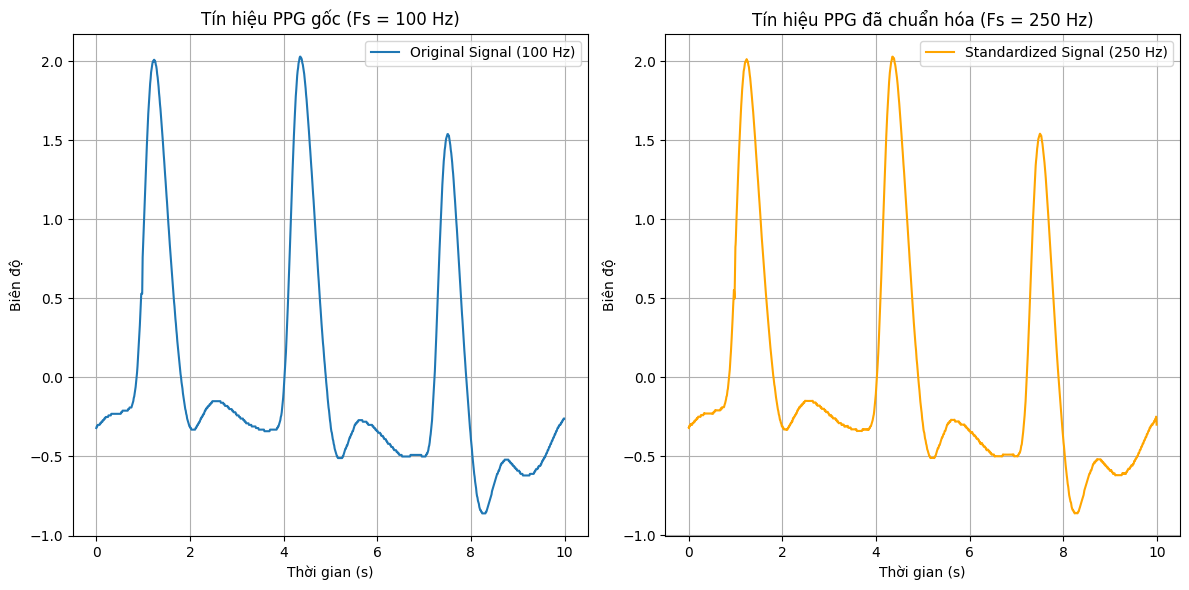

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Paths to the data files ---
# Adjust these paths if necessary based on your 'train_folder' variable
original_data_path = os.path.join(r'/kaggle/working/train_folder/', 'train_data.npz')
standardized_data_path = os.path.join(r'/kaggle/working/train_folder/', 'train_data_standardized.npz')

# --- Load one sample signal BEFORE standardization ---
try:
    original_data = np.load(original_data_path)
    # Let's take the first PPG signal segment
    original_ppg_sample = original_data['ppg'][0]
    # Determine original sampling rate based on length (assuming 10s window)
    original_length = len(original_ppg_sample)
    if abs(original_length - 1250) < abs(original_length - 1000): # Closer to 10s * 125Hz
        original_fs = 125
    else: # Closer to 10s * 100Hz
        original_fs = 100
    original_time_axis = np.arange(original_length) / original_fs
    print(f"Loaded original sample: Length={original_length}, Original Fs={original_fs} Hz")

except FileNotFoundError:
    print(f"Error: Original data file not found at {original_data_path}")
    original_ppg_sample = None

# --- Load the corresponding sample signal AFTER standardization ---
try:
    standardized_data = np.load(standardized_data_path)
    # Take the first PPG signal segment (should correspond to the original first one)
    standardized_ppg_sample = standardized_data['ppg'][0]
    standardized_fs = 250 # Target frequency
    standardized_length = len(standardized_ppg_sample)
    standardized_time_axis = np.arange(standardized_length) / standardized_fs
    print(f"Loaded standardized sample: Length={standardized_length}, Standardized Fs={standardized_fs} Hz")

except FileNotFoundError:
    print(f"Error: Standardized data file not found at {standardized_data_path}")
    standardized_ppg_sample = None

# --- Plotting for comparison (Figure 3.4) ---
if original_ppg_sample is not None and standardized_ppg_sample is not None:
    plt.figure(figsize=(12, 6))

    # Subplot 1: Original Signal
    plt.subplot(1, 2, 1)
    plt.plot(original_time_axis, original_ppg_sample, label=f'Original Signal ({original_fs} Hz)')
    plt.title(f'Tín hiệu PPG gốc (Fs = {original_fs} Hz)')
    plt.xlabel('Thời gian (s)')
    plt.ylabel('Biên độ')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Standardized Signal
    plt.subplot(1, 2, 2)
    plt.plot(standardized_time_axis, standardized_ppg_sample, label=f'Standardized Signal ({standardized_fs} Hz)', color='orange')
    plt.title(f'Tín hiệu PPG đã chuẩn hóa (Fs = {standardized_fs} Hz)')
    plt.xlabel('Thời gian (s)')
    plt.ylabel('Biên độ')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('figure_3_4_resampling_example.png') # Save the figure
    plt.show()
else:
    print("Could not generate plot because one or both data samples failed to load.")

In [12]:
def filter_and_normalize_signal(signal, fs, signal_type, filter_type='bandpass', normalize_method='minmax'):
    """
    Lọc nhiễu và chuẩn hóa biên độ tín hiệu
    Tham số:
    - signal: Mảng numpy chứa tín hiệu
    - fs: Tần số lấy mẫu (Hz)
    - filter_type: Loại bộ lọc ('bandpass', 'lowpass', 'highpass')
    - normalize_method: Phương pháp chuẩn hóa ('minmax', 'zscore')

    Trả về:
    - Tín hiệu đã lọc và chuẩn hóa
    """
    from scipy import signal as scipy_signal
    import numpy as np

    # Lọc nhiễu
    if filter_type == 'bandpass':
        if signal_type == 'ppg':  # ✅ Fix PPG filtering range
            b, a = scipy_signal.butter(4, [0.5, 8], fs=fs, btype='bandpass')
        else:  # ECG
            b, a = scipy_signal.butter(4, [0.5, 40], fs=fs, btype='bandpass')
    elif filter_type == 'lowpass':
        # Lọc thông thấp 1 Hz (phù hợp cho nhịp thở)
        b, a = scipy_signal.butter(4, 1, fs=fs, btype='lowpass')
    elif filter_type == 'highpass':
        # Lọc thông cao 0.5 Hz (loại bỏ trend)
        b, a = scipy_signal.butter(4, 0.5, fs=fs, btype='highpass')
    else:
        filtered_signal = signal  # Không lọc nếu loại không hợp lệ

    # Áp dụng bộ lọc nếu có
    if filter_type in ['bandpass', 'lowpass', 'highpass']:
        filtered_signal = scipy_signal.filtfilt(b, a, signal)

    # Kiểm tra NaN
    if np.isnan(filtered_signal).any():
        print("⚠️ Warning: NaN values detected after filtering! Returning zeros.")
        return np.zeros_like(filtered_signal)

    # Chuẩn hóa biên độ
    if normalize_method == 'minmax':
        # Chuẩn hóa Min-Max vào khoảng [-1, 1]
        signal_min = np.min(filtered_signal)
        signal_max = np.max(filtered_signal)
        if signal_max == signal_min:
            print("⚠️ Warning: Constant signal detected, skipping Min-Max normalization.")
            return np.zeros_like(filtered_signal)
        normalized_signal = 2 * (filtered_signal - signal_min) / (signal_max - signal_min) - 1
    elif normalize_method == 'zscore':
        # Chuẩn hóa Z-score
        signal_mean = np.mean(filtered_signal)
        signal_std = np.std(filtered_signal)
        if signal_std == 0:
            print("⚠️ Warning: Zero standard deviation detected, skipping Z-score normalization.")
            return np.zeros_like(filtered_signal)
        normalized_signal = (filtered_signal - signal_mean) / signal_std
    else:
        normalized_signal = filtered_signal

    return normalized_signal


def preprocess_dataset(data_path, fs=250):
    """
    Tiền xử lý toàn bộ bộ dữ liệu
    Tham số:
    - data_path: Đường dẫn đến file dữ liệu
    - fs: Tần số lấy mẫu (Hz)

    Trả về:
    - Đường dẫn đến file dữ liệu đã tiền xử lý
    """
    import numpy as np
    import os
    from tqdm import tqdm

    # Đọc dữ liệu
    data = np.load(data_path)
    ppg = data['ppg']
    ecg = data['ecg']
    resp = data['resp']

    # Tiền xử lý từng phân đoạn
    ppg_processed = []
    ecg_processed = []
    resp_processed = []

    for i in tqdm(range(len(ppg)), desc="🔄 Tiền xử lý tín hiệu"):
         # Xử lý tín hiệu PPG
         ppg_processed.append(filter_and_normalize_signal(
                ppg[i], fs, filter_type='bandpass', normalize_method='zscore', signal_type='ppg'  # ✅ Add signal_type='ppg'
            ))
         # Xử lý tín hiệu ECG
         ecg_processed.append(filter_and_normalize_signal(
                ecg[i], fs, filter_type='bandpass', normalize_method='minmax', signal_type='ecg'  # ✅ Add signal_type='ecg'
            ))
         # Xử lý tín hiệu nhịp thở
         resp_processed.append(filter_and_normalize_signal(
                resp[i], fs, filter_type='lowpass', normalize_method='minmax', signal_type='resp'  # ✅ Add signal_type='resp'
            ))

    # Chuyển đổi thành mảng numpy
    ppg_processed = np.array(ppg_processed)
    ecg_processed = np.array(ecg_processed)
    resp_processed = np.array(resp_processed)

    # In thông tin
    print(f"📊 Kích thước dữ liệu sau khi tiền xử lý:")
    print(f"   ➤ PPG: {ppg_processed.shape}")
    print(f"   ➤ ECG: {ecg_processed.shape}")
    print(f"   ➤ Nhịp thở: {resp_processed.shape}")

    # Lưu dữ liệu đã tiền xử lý
    output_dir = os.path.dirname(data_path)
    output_file = os.path.join(output_dir, os.path.basename(data_path).replace('.npz', '_preprocessed.npz'))
    np.savez_compressed(
        output_file,
        ppg=ppg_processed,
        ecg=ecg_processed,
        resp=resp_processed
    )

    print(f"✅ Đã lưu dữ liệu đã tiền xử lý tại: {output_file}")
    return output_file


# Tiền xử lý từng tập dữ liệu
train_prep_path = preprocess_dataset(train_std_path)
val_prep_path = preprocess_dataset(val_std_path)
test_prep_path = preprocess_dataset(test_std_path)


🔄 Tiền xử lý tín hiệu: 100%|██████████| 8385/8385 [00:12<00:00, 665.09it/s]


📊 Kích thước dữ liệu sau khi tiền xử lý:
   ➤ PPG: (8385, 2500)
   ➤ ECG: (8385, 2500)
   ➤ Nhịp thở: (8385, 2500)
✅ Đã lưu dữ liệu đã tiền xử lý tại: /kaggle/working/train_folder/train_data_standardized_preprocessed.npz


🔄 Tiền xử lý tín hiệu: 100%|██████████| 1797/1797 [00:02<00:00, 696.89it/s]


📊 Kích thước dữ liệu sau khi tiền xử lý:
   ➤ PPG: (1797, 2500)
   ➤ ECG: (1797, 2500)
   ➤ Nhịp thở: (1797, 2500)
✅ Đã lưu dữ liệu đã tiền xử lý tại: /kaggle/working/train_folder/val_data_standardized_preprocessed.npz


🔄 Tiền xử lý tín hiệu: 100%|██████████| 1797/1797 [00:02<00:00, 687.95it/s]


📊 Kích thước dữ liệu sau khi tiền xử lý:
   ➤ PPG: (1797, 2500)
   ➤ ECG: (1797, 2500)
   ➤ Nhịp thở: (1797, 2500)
✅ Đã lưu dữ liệu đã tiền xử lý tại: /kaggle/working/train_folder/test_data_standardized_preprocessed.npz


In [13]:
import numpy as np
from scipy import signal as scipy_signal
import os
from tqdm import tqdm

def extract_features(signal, fs, signal_type):
    """
    Trích xuất đặc trưng từ tín hiệu
    Tham số:
    - signal: Mảng numpy chứa tín hiệu
    - fs: Tần số lấy mẫu (Hz)
    - signal_type: Loại tín hiệu ('ppg', 'ecg', 'resp')
    Trả về:
    - Các đặc trưng đã trích xuất
    """
    # Trích xuất đặc trưng miền thời gian
    def extract_time_domain_features(signal):
        mean = np.mean(signal)
        std = np.std(signal)
        min_val = np.min(signal)
        max_val = np.max(signal)
        rms = np.sqrt(np.mean(np.square(signal)))
        zero_crossings = np.sum(np.diff(np.signbit(signal).astype(int)) != 0)
        zcr = zero_crossings / (len(signal) - 1)
        p2p = max_val - min_val
        hist, _ = np.histogram(signal, bins=10, density=True)
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        return np.array([mean, std, min_val, max_val, rms, zcr, p2p, entropy])

    # Trích xuất đặc trưng miền tần số
    def extract_frequency_domain_features(signal, fs):
        f, Pxx = scipy_signal.welch(signal, fs=fs, nperseg=min(len(signal), 256))
        mean_freq = np.sum(f * Pxx) / np.sum(Pxx) if np.sum(Pxx) > 0 else 0
        median_freq = f[np.where(np.cumsum(Pxx) >= np.sum(Pxx) / 2)[0][0]]
        max_freq = f[np.argmax(Pxx)]
        return np.array([mean_freq, median_freq, max_freq])

    # Trích xuất đặc trưng đặc thù theo loại tín hiệu
    def extract_signal_specific_features(signal, fs, signal_type):
        peaks, _ = scipy_signal.find_peaks(signal, distance=fs//2)
        peak_count = len(peaks)
        rate = (peak_count / (len(signal) / fs)) * 60 if len(signal) > 0 else 0
        if len(peaks) > 1:
            rr_intervals = np.diff(peaks) / fs
            sdnn = np.std(rr_intervals) if len(rr_intervals) > 1 else 0
            rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals)))) if len(rr_intervals) > 2 else 0
        else:
            sdnn, rmssd = 0, 0

        resp_rate = rate if signal_type == 'resp' else 0
        return np.array([peak_count, rate, sdnn, rmssd, resp_rate])

    return np.concatenate([
        extract_time_domain_features(signal),
        extract_frequency_domain_features(signal, fs),
        extract_signal_specific_features(signal, fs, signal_type)
    ])

def extract_features_from_dataset(data_path, fs=250, sample_count=None):
    """
    Trích xuất đặc trưng từ bộ dữ liệu
    Tham số:
    - data_path: Đường dẫn đến file dữ liệu
    - fs: Tần số lấy mẫu (Hz)
    - sample_count: Số lượng mẫu cần trích xuất (None = toàn bộ)
    Trả về:
    - Đường dẫn đến file đặc trưng đã trích xuất
    """
    # Đọc dữ liệu
    data = np.load(data_path)
    ppg, ecg, resp = data['ppg'], data['ecg'], data['resp']
    if sample_count is not None:
        sample_count = min(sample_count, len(ppg))
        ppg, ecg, resp = ppg[:sample_count], ecg[:sample_count], resp[:sample_count]

    # Trích xuất đặc trưng
    ppg_features = np.array([extract_features(ppg[i], fs, 'ppg') for i in tqdm(range(len(ppg)), desc="PPG")])
    ecg_features = np.array([extract_features(ecg[i], fs, 'ecg') for i in tqdm(range(len(ecg)), desc="ECG")])
    resp_features = np.array([extract_features(resp[i], fs, 'resp') for i in tqdm(range(len(resp)), desc="RESP")])

    # Lưu đặc trưng đã trích xuất
    output_file = data_path.replace('.npz', '_features.npz')
    np.savez_compressed(output_file, ppg=ppg, ecg=ecg, resp=resp, ppg_features=ppg_features, ecg_features=ecg_features, resp_features=resp_features)
    print(f"Đã lưu đặc trưng tại: {output_file}")
    return output_file

train_features_path = extract_features_from_dataset(train_prep_path, sample_count=1000)


RESP: 100%|██████████| 1000/1000 [00:00<00:00, 1361.97it/s]


Đã lưu đặc trưng tại: /kaggle/working/train_folder/train_data_standardized_preprocessed_features.npz


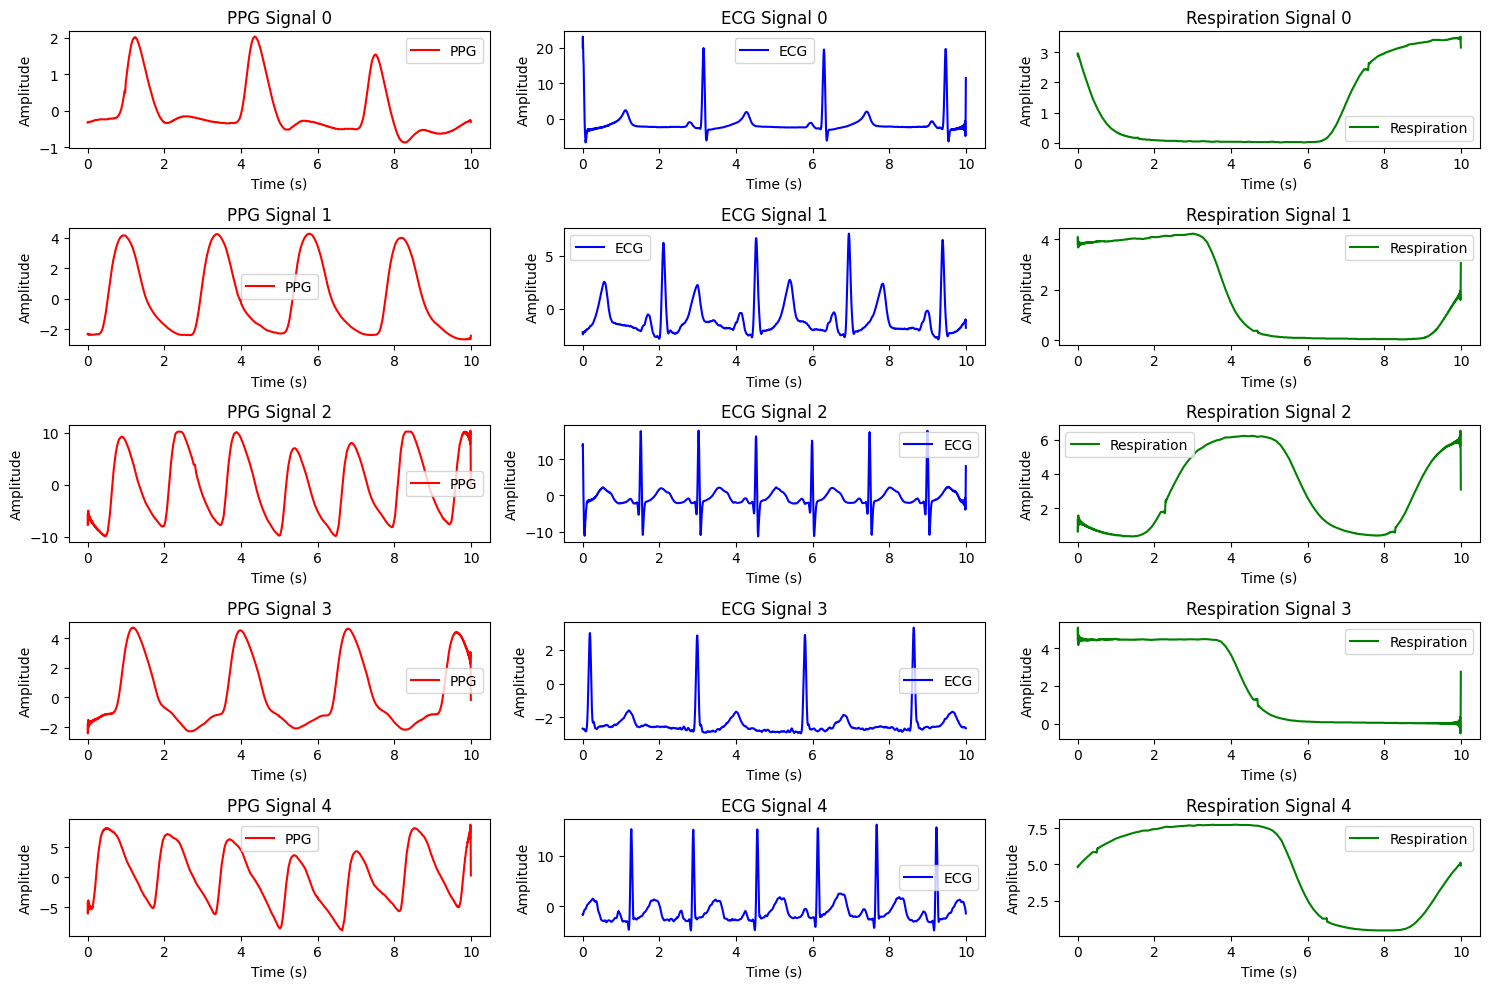

In [14]:
def visualize_signals(data_path, num_samples=5, fs=250):
    data = np.load(data_path)
    ppg, ecg, resp = data['ppg'], data['ecg'], data['resp']

    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(ppg))):
        time = np.arange(len(ppg[i])) / fs

        plt.subplot(num_samples, 3, 3 * i + 1)
        plt.plot(time, ppg[i], label='PPG', color='r')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title(f'PPG Signal {i}')
        plt.legend()

        plt.subplot(num_samples, 3, 3 * i + 2)
        plt.plot(time, ecg[i], label='ECG', color='b')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title(f'ECG Signal {i}')
        plt.legend()

        plt.subplot(num_samples, 3, 3 * i + 3)
        plt.plot(time, resp[i], label='Respiration', color='g')
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.title(f'Respiration Signal {i}')
        plt.legend()

    plt.tight_layout()
    plt.show()

visualize_signals(train_std_path)

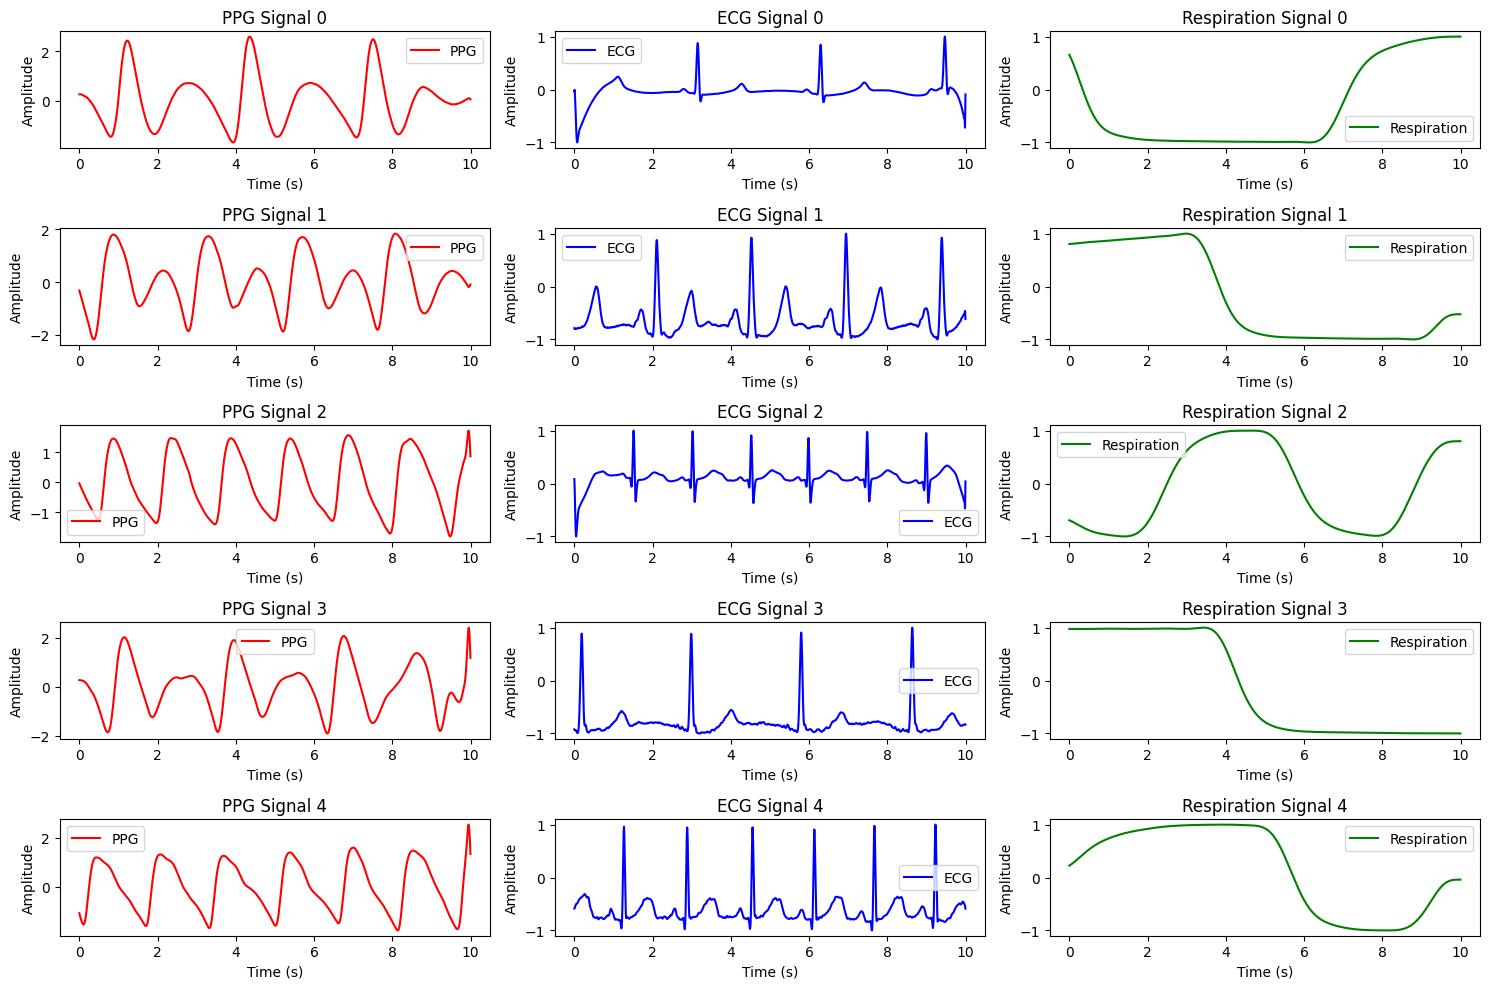

In [15]:
visualize_signals(train_prep_path)

In [16]:
import numpy as np
import os
from tqdm import tqdm

def prepare_data_for_training(data_path, sequence_length=2500):
    """
    Chuẩn bị dữ liệu cho việc huấn luyện mô hình tạo sinh.

    Tham số:
    - data_path: Đường dẫn đến file dữ liệu đã tiền xử lý.
    - sequence_length: Độ dài chuỗi (số điểm dữ liệu).

    Trả về:
    - Đường dẫn đến file dữ liệu đã chuẩn bị.
    """

    # Đọc dữ liệu
    data = np.load(data_path)
    ppg = data['ppg']
    ecg = data['ecg']
    resp = data['resp']

    # Đảm bảo tất cả các tín hiệu có cùng độ dài
    min_length = min(ppg.shape[1], ecg.shape[1], resp.shape[1])

    # Cắt hoặc đệm dữ liệu theo sequence_length
    if min_length >= sequence_length:
        ppg_cut = ppg[:, :sequence_length]
        ecg_cut = ecg[:, :sequence_length]
        resp_cut = resp[:, :sequence_length]
    else:
        # Padding nếu độ dài nhỏ hơn sequence_length
        ppg_cut = np.zeros((ppg.shape[0], sequence_length))
        ecg_cut = np.zeros((ecg.shape[0], sequence_length))
        resp_cut = np.zeros((resp.shape[0], sequence_length))

        ppg_cut[:, :min_length] = ppg[:, :min_length]
        ecg_cut[:, :min_length] = ecg[:, :min_length]
        resp_cut[:, :min_length] = resp[:, :min_length]

    # Thêm chiều kênh (cần thiết cho mô hình CNN)
    ppg_input = ppg_cut.reshape(ppg_cut.shape[0], ppg_cut.shape[1], 1)
    ecg_target = ecg_cut.reshape(ecg_cut.shape[0], ecg_cut.shape[1], 1)
    resp_target = resp_cut.reshape(resp_cut.shape[0], resp_cut.shape[1], 1)

    # In thông tin kích thước dữ liệu
    print(f"Kích thước dữ liệu huấn luyện:")
    print(f"PPG (đầu vào): {ppg_input.shape}")
    print(f"ECG (đầu ra): {ecg_target.shape}")
    print(f"Nhịp thở (đầu ra): {resp_target.shape}")

    # Lưu dữ liệu đã chuẩn bị
    output_dir = os.path.dirname(data_path)
    output_file = os.path.join(output_dir, os.path.basename(data_path).replace('.npz', '_training.npz'))

    np.savez_compressed(output_file, ppg_input=ppg_input, ecg_target=ecg_target, resp_target=resp_target)

    print(f"Đã lưu dữ liệu huấn luyện tại: {output_file}")

    return output_file

# Chuẩn bị dữ liệu huấn luyện
train_ready_path = prepare_data_for_training(train_prep_path)
val_ready_path = prepare_data_for_training(val_prep_path)
test_ready_path = prepare_data_for_training(test_prep_path)


Kích thước dữ liệu huấn luyện:
PPG (đầu vào): (8385, 2500, 1)
ECG (đầu ra): (8385, 2500, 1)
Nhịp thở (đầu ra): (8385, 2500, 1)
Đã lưu dữ liệu huấn luyện tại: /kaggle/working/train_folder/train_data_standardized_preprocessed_training.npz
Kích thước dữ liệu huấn luyện:
PPG (đầu vào): (1797, 2500, 1)
ECG (đầu ra): (1797, 2500, 1)
Nhịp thở (đầu ra): (1797, 2500, 1)
Đã lưu dữ liệu huấn luyện tại: /kaggle/working/train_folder/val_data_standardized_preprocessed_training.npz
Kích thước dữ liệu huấn luyện:
PPG (đầu vào): (1797, 2500, 1)
ECG (đầu ra): (1797, 2500, 1)
Nhịp thở (đầu ra): (1797, 2500, 1)
Đã lưu dữ liệu huấn luyện tại: /kaggle/working/train_folder/test_data_standardized_preprocessed_training.npz


In [17]:
import os
train_folder = r"/kaggle/working/train_folder/"
train_ready_path = os.path.join(train_folder,"train_data_standardized_preprocessed_training.npz")
val_ready_path = os.path.join(train_folder,"val_data_standardized_preprocessed_training.npz")
test_ready_path = os.path.join(train_folder,"test_data_standardized_preprocessed_training.npz")

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class BioSignalDataset(Dataset):
    """
    Lớp Dataset cho dữ liệu tín hiệu sinh học.
    """

    def __init__(self, data_path):
        # Đọc dữ liệu
        data = np.load(data_path)
        self.ppg_input = torch.tensor(data['ppg_input'], dtype=torch.float32)
        self.ecg_target = torch.tensor(data['ecg_target'], dtype=torch.float32)
        self.resp_target = torch.tensor(data['resp_target'], dtype=torch.float32)
        self.num_samples = self.ppg_input.shape[0]
        print(data['ppg_input'].shape)
        print(data['ecg_target'].shape)
        print(data['resp_target'].shape)


    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return {
            'ppg': self.ppg_input[idx],
            'ecg': self.ecg_target[idx],
            'resp': self.resp_target[idx]
        }

def create_dataloaders(train_path, val_path, test_path, batch_size=32):
    """
    Tạo DataLoader cho tập huấn luyện, xác thực và kiểm tra.

    Tham số:
    - train_path, val_path, test_path: Đường dẫn đến file dữ liệu.
    - batch_size: Kích thước batch.

    Trả về:
    - train_loader, val_loader, test_loader: DataLoader.
    """

    # Tạo Dataset
    train_dataset = BioSignalDataset(train_path)
    val_dataset = BioSignalDataset(val_path)
    test_dataset = BioSignalDataset(test_path)

    # Tạo DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

# Tạo DataLoader
train_loader, val_loader, test_loader = create_dataloaders(
    train_ready_path, val_ready_path, test_ready_path, batch_size=16
)
train_loader_32, val_loader_32, test_loader_32 = create_dataloaders(
    train_ready_path, val_ready_path, test_ready_path, batch_size=32
)

(8385, 2500, 1)
(8385, 2500, 1)
(8385, 2500, 1)
(1797, 2500, 1)
(1797, 2500, 1)
(1797, 2500, 1)
(1797, 2500, 1)
(1797, 2500, 1)
(1797, 2500, 1)
(8385, 2500, 1)
(8385, 2500, 1)
(8385, 2500, 1)
(1797, 2500, 1)
(1797, 2500, 1)
(1797, 2500, 1)
(1797, 2500, 1)
(1797, 2500, 1)
(1797, 2500, 1)


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
!pip install pytorch_msssim
import pytorch_msssim  # For SSIM loss

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.se = nn.Identity()  # Placeholder for Squeeze-Excitation block

        self.residual_conv = None
        if in_channels != out_channels:
            self.residual_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = self.se(x)

        if self.residual_conv:
            residual = self.residual_conv(residual)

        return F.relu(x + residual)

class DualUNet(nn.Module):
    def __init__(self, in_channels=1, ecg_channels=1, resp_channels=1):
        super(DualUNet, self).__init__()

        self.encoder = nn.Sequential(
            DoubleConv(in_channels, 64),
            nn.MaxPool1d(kernel_size=2, stride=2),
            DoubleConv(64, 128),
            nn.MaxPool1d(kernel_size=2, stride=2),
            DoubleConv(128, 256),
            nn.MaxPool1d(kernel_size=2, stride=2),
            DoubleConv(256, 512),
        )

        self.ecg_decoder = self._make_decoder(512, ecg_channels)
        self.resp_decoder = self._make_decoder(512, resp_channels)

    def _make_decoder(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose1d(in_channels, 256, kernel_size=2, stride=2),
            DoubleConv(256, 128),
            nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2),
            DoubleConv(64, 64),
            nn.ConvTranspose1d(64, 32, kernel_size=2, stride=2),
            DoubleConv(32, 32),
            nn.Conv1d(32, out_channels, kernel_size=1)
        )

    def forward(self, x):
        original_length = x.shape[2]
        x = self.pad_to_multiple(x, 8)
        features = self.encoder(x)
        ecg = self.crop_to_length(self.ecg_decoder(features), original_length)
        resp = self.crop_to_length(self.resp_decoder(features), original_length)
        return ecg, resp

    @staticmethod
    def pad_to_multiple(x, multiple=8):
        pad_len = (multiple - x.shape[2] % multiple) % multiple
        return F.pad(x, (0, pad_len))

    @staticmethod
    def crop_to_length(x, target_length):
        return x[:, :, :target_length]

class CustomLoss(nn.Module):
    def __init__(self, alpha=0.8, beta=0.2, l1_weight=0.01):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.l1_weight = l1_weight
        self.ssim_loss = pytorch_msssim.SSIM(data_range=1.0, size_average=True, channel=1)

    def forward(self, ecg_pred, ecg_target, resp_pred, resp_target):
        mse_ecg = F.mse_loss(ecg_pred, ecg_target)
        mse_resp = F.mse_loss(resp_pred, resp_target)

        ssim_ecg = 1 - self.ssim_loss(ecg_pred, ecg_target)
        ssim_resp = 1 - self.ssim_loss(resp_pred, resp_target)

        l1_reg = (ecg_pred.abs().mean() + resp_pred.abs().mean()) * self.l1_weight

        loss = self.alpha * (mse_ecg + mse_resp) + self.beta * (ssim_ecg + ssim_resp) + l1_reg
        return loss


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

class Generator(nn.Module):
    """
    Mô hình Generator cho GAN - tạo sinh ECG và nhịp thở từ PPG.
    """
    def __init__(self, in_channels=1, latent_dim=100, out_channels=1):
        super(Generator, self).__init__()

        # Phần xử lý tín hiệu PPG
        self.ppg_encoder = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=7, stride=1, padding=3),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Phần xử lý nhiễu ngẫu nhiên
        self.latent_processor = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        # Phần tạo sinh ECG
        self.ecg_decoder = nn.Sequential(
        nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.BatchNorm1d(64),
        nn.ReLU(inplace=True),
        nn.Conv1d(64, out_channels, kernel_size=7, stride=1, padding=3),
        nn.Tanh()
        )

        # Phần tạo sinh nhịp thở
        self.resp_decoder = nn.Sequential(
        nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
        nn.BatchNorm1d(64),
        nn.ReLU(inplace=True),
        nn.Conv1d(64, out_channels, kernel_size=7, stride=1, padding=3),
        nn.Tanh()
        )


    def forward(self, ppg, noise=None):
        # Mã hóa PPG
        ppg_features = self.ppg_encoder(ppg)

        # Kết hợp với nhiễu nếu có
        if noise is not None:
            latent_features = self.latent_processor(noise)
            latent_features = latent_features.unsqueeze(2).expand(-1, -1, ppg_features.size(2))
            features = ppg_features + latent_features
        else:
            features = ppg_features

        # Giải mã thành ECG và nhịp thở
        ecg = self.ecg_decoder(features)
        resp = self.resp_decoder(features)
        pool = nn.AdaptiveAvgPool1d(2500)
        ecg = pool(ecg)
        resp = pool(resp)
        return ecg, resp

class Discriminator(nn.Module):
    """
    Mô hình Discriminator cho GAN - phân biệt tín hiệu thật/giả.
    """
    def __init__(self, in_channels=3):  # 3 = PPG + ECG + Resp
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # Layer 1
            nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 2
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 3
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 4
            nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # Layer 5 (Output)
            nn.Conv1d(512, 1, kernel_size=3, stride=1, padding=1),
        )
        self.pool = nn.AdaptiveAvgPool1d(312)  # Dynamically set output length
        self.main.add_module("sigmoid", nn.Sigmoid())

    def forward(self, ppg, ecg, resp):
        # Ghép các đầu vào lại với nhau

        x = torch.cat((ppg, ecg, resp), dim=1)
        x = self.main(x)
        x = self.pool(x)
        return x

import torch
import torch.nn as nn

class GeneratorLSTM(nn.Module):
    """
    LSTM Generator Model for time-series signal synthesis.
    Predicts both ECG and Resp signals from PPG input.
    """

    def __init__(self, input_size: int = 1, hidden_size: int = 128, num_layers: int = 2,
                 dropout: float = 0.1, output_size: int = 1, bidirectional: bool = False):
        super(GeneratorLSTM, self).__init__()

        # Factor for bidirectional LSTM (1 if False, 2 if True)
        factor = 2 if bidirectional else 1

        # LSTM Layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,  # Avoid dropout for single-layer LSTM
            batch_first=True,
            bidirectional=bidirectional
        )

        # ECG Output Layer
        self.ecg_fc = nn.Sequential(
            nn.Linear(hidden_size * factor, hidden_size),  # Adjusted for bidirectionality
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

        # Respiration Output Layer
        self.resp_fc = nn.Sequential(
            nn.Linear(hidden_size * factor, hidden_size),  # Adjusted for bidirectionality
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input tensor of shape (batch_size, seq_len, input_size)

        Returns:
            ecg (Tensor): Predicted ECG signal (batch_size, seq_len, output_size)
            resp (Tensor): Predicted Resp signal (batch_size, seq_len, output_size)
        """
        # LSTM processing
        lstm_out, _ = self.lstm(x)  # Output shape: (batch_size, seq_len, hidden_size * factor)

        # Predict ECG and Resp from LSTM features
        ecg = self.ecg_fc(lstm_out)  # Output shape: (batch_size, seq_len, output_size)
        resp = self.resp_fc(lstm_out)

        return ecg, resp




In [21]:
def initialize_models(model_type='unet'):
    """
    Khởi tạo mô hình dựa trên loại
    Tham số:
    - model_type: Loại mô hình ('unet', 'gan', 'lstm')
    Trả về:
    - Các mô hình và tối ưu hóa tương ứng
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if model_type == 'unet':
        # Khởi tạo mô hình UNet kép
        model = DualUNet().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        return model, optimizer, criterion

    elif model_type == 'gan':
        # Khởi tạo Generator và Discriminator
        latent_dim = 100
        generator = Generator(latent_dim=latent_dim).to(device)
        discriminator = Discriminator().to(device)

        # Tối ưu hóa
        g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        # Hàm mất mát
        adversarial_loss = nn.BCEWithLogitsLoss()
        reconstruction_loss = nn.L1Loss()

        return generator, discriminator, g_optimizer, d_optimizer, adversarial_loss, reconstruction_loss, latent_dim

    elif model_type == 'lstm':
        # Khởi tạo mô hình LSTM
        model = GeneratorLSTM().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.MSELoss()
        return model, optimizer, criterion

    else:
        raise ValueError(f"Loại mô hình không hỗ trợ: {model_type}")

# Khởi tạo mô hình U-Net
unet_model, unet_optimizer, unet_criterion = initialize_models('unet')

# Khởi tạo mô hình GAN
gan_generator, gan_discriminator, g_optimizer, d_optimizer, adversarial_loss, reconstruction_loss, latent_dim = initialize_models('gan')

# Khởi tạo mô hình LSTM
lstm_model, lstm_optimizer, lstm_criterion = initialize_models('lstm')

import os
models_path = os.path.join(r"/kaggle/working/train_folder/models")


In [22]:
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn

def train_unet(
    model, optimizer, criterion, train_loader, val_loader,
    num_epochs=50, device=None, save_path="models/unet_model.pth", scheduler=None, models_path = r'/kaggle/working/train_folder/models'
):
    """
    Train the U-Net model with a learning rate scheduler.

    Args:
    - model: The U-Net model
    - optimizer: Optimizer for training
    - criterion: Loss function
    - train_loader: DataLoader for training
    - val_loader: DataLoader for validation
    - num_epochs: Number of epochs (default: 50)
    - device: Training device (CPU or GPU)
    - save_path: Path to save the best model
    - scheduler: Learning rate scheduler (optional)
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_losses, val_losses = [], []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            ppg = batch['ppg'].to(device).permute(0, 2, 1)
            ecg = batch['ecg'].to(device).permute(0, 2, 1)
            resp = batch['resp'].to(device).permute(0, 2, 1)

            optimizer.zero_grad()
            ecg_pred, resp_pred = model(ppg)

            loss = criterion(ecg_pred, ecg) + criterion(resp_pred, resp)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        if scheduler:
            scheduler.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                ppg = batch['ppg'].to(device).permute(0, 2, 1)
                ecg = batch['ecg'].to(device).permute(0, 2, 1)
                resp = batch['resp'].to(device).permute(0, 2, 1)

                ecg_pred, resp_pred = model(ppg)
                loss = criterion(ecg_pred, ecg) + criterion(resp_pred, resp)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.6e}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ Model saved to {save_path}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(models_path,'unet_training_loss.png'))
    plt.show()

    return train_losses, val_losses


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_lstm(model, optimizer, criterion, train_loader, val_loader,
               num_epochs=50, device=None, save_path="models/lstm_model.pth", scheduler=None, models_path = r'/kaggle/working/train_folder/models'):
    """
    Huấn luyện mô hình LSTM với learning rate scheduler.

    Tham số:
    - model: Mô hình LSTM cần huấn luyện.
    - optimizer: Bộ tối ưu hóa (Adam, SGD, v.v.).
    - criterion: Hàm mất mát (MSELoss, L1Loss, v.v.).
    - train_loader: DataLoader cho tập huấn luyện.
    - val_loader: DataLoader cho tập validation.
    - num_epochs: Số lượng epoch để huấn luyện.
    - device: Thiết bị tính toán (CPU/GPU).
    - save_path: Đường dẫn lưu mô hình tốt nhất.
    - scheduler: Bộ điều chỉnh learning rate (tuỳ chọn).

    Trả về:
    - train_losses: Danh sách loss huấn luyện theo epoch.
    - val_losses: Danh sách loss validation theo epoch.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    # Lưu lịch sử huấn luyện
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # ----- Huấn luyện -----
        model.train()
        train_loss = 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            # Lấy dữ liệu
            ppg = batch['ppg'].to(device)  # (batch_size, sequence_length, 1)
            ecg = batch['ecg'].to(device)
            resp = batch['resp'].to(device)

            # Forward pass
            optimizer.zero_grad()
            ecg_pred, resp_pred = model(ppg)

            # Tính loss
            ecg_loss = criterion(ecg_pred, ecg)
            resp_loss = criterion(resp_pred, resp)
            loss = ecg_loss + resp_loss

            # Backward pass và tối ưu hóa
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Cập nhật learning rate nếu có scheduler
        if scheduler:
            scheduler.step()

        # Tính loss trung bình
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # ----- Đánh giá -----
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                # Lấy dữ liệu
                ppg = batch['ppg'].to(device)
                ecg = batch['ecg'].to(device)
                resp = batch['resp'].to(device)

                # Forward pass
                ecg_pred, resp_pred = model(ppg)

                # Tính loss
                ecg_loss = criterion(ecg_pred, ecg)
                resp_loss = criterion(resp_pred, resp)
                loss = ecg_loss + resp_loss

                val_loss += loss.item()

        # Tính loss trung bình
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # In tiến trình
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch [{epoch+1}/{num_epochs}], LR: {current_lr:.6e}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

        # Lưu mô hình tốt nhất
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print(f"✅ Model saved to {save_path}")

    # Vẽ đồ thị loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(models_path,'ltms_training_loss.png'))
    plt.show()

    return train_losses, val_losses



In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

def train_gan(generator, discriminator, g_optimizer, d_optimizer,
              adversarial_loss, reconstruction_loss,
              latent_dim, train_loader, val_loader, num_epochs=50, device=None,
              save_path="models/gan_model.pth",models_path = r'/kaggle/working/train_folder/models'):
    """
    Huấn luyện mô hình GAN

    Tham số:
    - generator, discriminator: Mô hình Generator và Discriminator
    - g_optimizer, d_optimizer: Tối ưu hóa cho Generator và Discriminator
    - adversarial_loss, reconstruction_loss: Hàm mất mát
    - latent_dim: Kích thước vector nhiễu
    - train_loader, val_loader: DataLoader
    - num_epochs: Số epoch
    - device: Thiết bị tính toán
    - save_path: Đường dẫn lưu mô hình
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Lưu lịch sử huấn luyện
    d_losses, g_losses, val_losses = [], [], []
    best_val_loss = float('inf')
    real_label, fake_label = 1.0, 0.0

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        d_loss_epoch, g_loss_epoch = 0.0, 0.0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            ppg = batch['ppg'].to(device)  # (batch_size, sequence_length, 1)
            ecg = batch['ecg'].to(device)
            resp = batch['resp'].to(device)

            ppg = ppg.permute(0, 2, 1)  # (batch_size, 1, sequence_length)
            ecg = ecg.permute(0, 2, 1)
            resp = resp.permute(0, 2, 1)
            batch_size = ppg.size(0)

            # Huấn luyện Discriminator
            d_optimizer.zero_grad()
            real_labels = torch.full((batch_size, 1, ppg.size(2) // 8), 0.9, device=device)
            fake_labels = torch.full((batch_size, 1, ppg.size(2) // 8), 0.1, device=device)

            real_output = discriminator(ppg, ecg, resp)
            d_real_loss = adversarial_loss(real_output, real_labels)

            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_ecg, fake_resp = generator(ppg, noise)

            fake_output = discriminator(ppg, fake_ecg.detach(), fake_resp.detach())
            d_fake_loss = adversarial_loss(fake_output, fake_labels)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # Huấn luyện Generator
            g_optimizer.zero_grad()
            fake_output = discriminator(ppg, fake_ecg, fake_resp)
            g_adv_loss = adversarial_loss(fake_output, real_labels)

            g_rec_ecg_loss = reconstruction_loss(fake_ecg, ecg)
            g_rec_resp_loss = reconstruction_loss(fake_resp, resp)
            g_rec_loss = g_rec_ecg_loss + g_rec_resp_loss

            lambda_rec = 0.5
            g_loss = g_adv_loss + lambda_rec * g_rec_loss
            g_loss.backward()
            g_optimizer.step()

            d_loss_epoch += d_loss.item()
            g_loss_epoch += g_loss.item()

        d_losses.append(d_loss_epoch / len(train_loader))
        g_losses.append(g_loss_epoch / len(train_loader))

        # Đánh giá
        generator.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                ppg = batch['ppg'].to(device)
                ecg = batch['ecg'].to(device)
                resp = batch['resp'].to(device)

                ppg = ppg.permute(0, 2, 1)
                ecg = ecg.permute(0, 2, 1)
                resp = resp.permute(0, 2, 1)

                fake_ecg, fake_resp = generator(ppg)

                ecg_loss = reconstruction_loss(fake_ecg, ecg)
                resp_loss = reconstruction_loss(fake_resp, resp)
                loss = ecg_loss + resp_loss
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], D Loss: {d_losses[-1]:.6f}, G Loss: {g_losses[-1]:.6f}, Val Loss: {val_losses[-1]:.6f}")

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            torch.save({
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
            }, save_path)
            print(f"Model saved to {save_path}")

    # Vẽ đồ thị loss
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, label='Discriminator Loss')
    plt.plot(g_losses, label='Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Adversarial Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(models_path,'gan_training_loss.png'))
    plt.show()

    return d_losses, g_losses, val_losses

In [25]:
import os
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

# Define paths and create necessary directories
models_path = os.path.join(r"/kaggle/working/train_folder/", "models")
os.makedirs(models_path, exist_ok=True)
print(f"✅ Models folder created at: {models_path}")

# Kiểm tra số lượng GPU có sẵn
num_gpus = torch.cuda.device_count()
print("Số GPU có sẵn:", num_gpus)

# Nếu có hơn 1 GPU, bọc các mô hình bằng DataParallel
if num_gpus > 1:
    unet_model = nn.DataParallel(unet_model)
    gan_generator = nn.DataParallel(gan_generator)
    gan_discriminator = nn.DataParallel(gan_discriminator)
    lstm_model = nn.DataParallel(lstm_model)

# Chuyển các mô hình sang GPU
unet_model = unet_model.to('cuda')
gan_generator = gan_generator.to('cuda')
gan_discriminator = gan_discriminator.to('cuda')
lstm_model = lstm_model.to('cuda')

# Define training epochs
UNET_EPOCHS = 100
GAN_EPOCHS = 150
LSTM_EPOCHS = 250

# Learning rate schedulers
unet_scheduler = lr_scheduler.CosineAnnealingLR(unet_optimizer, T_max=UNET_EPOCHS)
lstm_scheduler = lr_scheduler.CosineAnnealingLR(lstm_optimizer, T_max=LSTM_EPOCHS)

# Train U-Net model
print("🔄 Training U-Net...")
unet_train_losses, unet_val_losses = train_unet(
    model=unet_model,
    optimizer=unet_optimizer,
    criterion=unet_criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=UNET_EPOCHS,
    save_path=os.path.join(models_path, "unet_model.pth"),
    scheduler=unet_scheduler
)

# Train GAN model
print("\nĐang huấn luyện mô hình GAN...")
gan_d_losses, gan_g_losses, gan_val_losses = train_gan(
    gan_generator, gan_discriminator,
    g_optimizer, d_optimizer,
    adversarial_loss, reconstruction_loss, latent_dim,
    train_loader, val_loader,
    num_epochs=GAN_EPOCHS,
    save_path=os.path.join(models_path, "gan_model.pth")
)

# Train LSTM model
print("\n🔄 Đang huấn luyện mô hình LSTM...")
lstm_train_losses, lstm_val_losses = train_lstm(
    lstm_model, lstm_optimizer, lstm_criterion,
    train_loader_32, val_loader_32,
    num_epochs=LSTM_EPOCHS,
    save_path=os.path.join(models_path, "newlstm_model.pth"),
    scheduler=lstm_scheduler
)


✅ Models folder created at: /kaggle/working/train_folder/models
Số GPU có sẵn: 2
🔄 Training U-Net...


Epoch 1/100 - Validation: 100%|██████████| 113/113 [00:03<00:00, 28.29it/s]


Epoch [1/100], LR: 9.997533e-04, Train Loss: 0.803859, Val Loss: 0.802327
✅ Model saved to /kaggle/working/train_folder/models/unet_model.pth


Epoch 2/100 - Validation: 100%|██████████| 113/113 [00:03<00:00, 28.57it/s]


Epoch [2/100], LR: 9.990134e-04, Train Loss: 0.796890, Val Loss: 0.801817
✅ Model saved to /kaggle/working/train_folder/models/unet_model.pth


Epoch 3/100 - Validation: 100%|██████████| 113/113 [00:04<00:00, 28.21it/s]


Epoch [3/100], LR: 9.977810e-04, Train Loss: 0.795865, Val Loss: 0.801997


Epoch 4/100 - Validation: 100%|██████████| 113/113 [00:04<00:00, 28.08it/s]


Epoch [4/100], LR: 9.960574e-04, Train Loss: 0.793929, Val Loss: 0.800461
✅ Model saved to /kaggle/working/train_folder/models/unet_model.pth


Epoch 5/100 - Validation: 100%|██████████| 113/113 [00:04<00:00, 28.17it/s]


Epoch [5/100], LR: 9.938442e-04, Train Loss: 0.791906, Val Loss: 0.795389
✅ Model saved to /kaggle/working/train_folder/models/unet_model.pth


Epoch 6/100 - Validation: 100%|██████████| 113/113 [00:03<00:00, 28.43it/s]


Epoch [6/100], LR: 9.911436e-04, Train Loss: 0.790038, Val Loss: 0.794221
✅ Model saved to /kaggle/working/train_folder/models/unet_model.pth


Epoch 7/100 - Validation: 100%|██████████| 113/113 [00:03<00:00, 28.32it/s]


Epoch [7/100], LR: 9.879584e-04, Train Loss: 0.787913, Val Loss: 0.789277
✅ Model saved to /kaggle/working/train_folder/models/unet_model.pth


Epoch 8/100 - Validation: 100%|██████████| 113/113 [00:03<00:00, 28.61it/s]


Epoch [8/100], LR: 9.842916e-04, Train Loss: 0.785858, Val Loss: 0.790072


Epoch 9/100 - Validation: 100%|██████████| 113/113 [00:04<00:00, 27.53it/s]


Epoch [9/100], LR: 9.801468e-04, Train Loss: 0.782821, Val Loss: 0.786411
✅ Model saved to /kaggle/working/train_folder/models/unet_model.pth


Epoch 10/100 - Training:  53%|█████▎    | 278/525 [00:18<00:16, 15.27it/s]


KeyboardInterrupt: 

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plot_path = r'/kaggle/working/train_folder/models'

print("Training loss của Unet")
img = mpimg.imread(os.path.join(plot_path,"unet_training_loss.png"))  # Replace with the actual file path
plt.figure(figsize=(10, 6))  # Set figure size
plt.imshow(img)  # Display image
plt.axis('off')  # Hide axes for a cleaner view
plt.show()

print("Training loss của Gan")
img = mpimg.imread(os.path.join(plot_path,"gan_training_loss.png"))  # Replace with the actual file path
plt.figure(figsize=(10, 6))  # Set figure size
plt.imshow(img)  # Display image
plt.axis('off')  # Hide axes for a cleaner view
plt.show()


print("Training loss của LSTM")
img = mpimg.imread(os.path.join(plot_path,"ltms_training_loss.png"))  # Replace with the actual file path
plt.figure(figsize=(10, 6))  # Set figure size
plt.imshow(img)  # Display image
plt.axis('off')  # Hide axes for a cleaner view
plt.show()



In [ ]:
import os
import torch

def remove_module_prefix(state_dict):
    """Loại bỏ tiền tố 'module.' khỏi các key của state_dict."""
    new_state_dict = {}
    for key, value in state_dict.items():
        new_key = key.replace("module.", "")
        new_state_dict[new_key] = value
    return new_state_dict

def load_models():
    """
    Tải các mô hình đã huấn luyện.

    Returns:
        unet_model, gan_generator, lstm_model: Các mô hình đã được tải.
    """
    models_path = os.path.join(train_folder, "models")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Tải mô hình U-Net
    unet_path = os.path.join(models_path, "unet_model.pth")
    unet_model = DualUNet().to(device)
    state_dict = torch.load(unet_path, map_location=device,weights_only=True)
    # Nếu state_dict có tiền tố "module.", loại bỏ nó:
    state_dict = remove_module_prefix(state_dict)
    unet_model.load_state_dict(state_dict)
    unet_model.eval()

    # Tải mô hình GAN
    gan_path = os.path.join(models_path, "gan_model.pth")
    gan_generator = Generator().to(device)
    gan_checkpoint = torch.load(gan_path, map_location=device,weights_only=True)
    # Loại bỏ tiền tố "module." nếu cần (ở đây giả sử checkpoint chứa key 'generator'):
    gan_state_dict = remove_module_prefix(gan_checkpoint['generator'])
    gan_generator.load_state_dict(gan_state_dict)
    gan_generator.eval()

    # Tải mô hình LSTM
    lstm_path = os.path.join(models_path, "newlstm_model.pth")
    lstm_model = GeneratorLSTM().to(device)
    lstm_state_dict = torch.load(lstm_path, map_location=device,weights_only=True)
    lstm_state_dict = remove_module_prefix(lstm_state_dict)
    lstm_model.load_state_dict(lstm_state_dict)
    lstm_model.eval()

    return unet_model, gan_generator, lstm_model

# Tải các mô hình
unet_model, gan_generator, lstm_model = load_models()
print("Các mô hình đã được tải thành công.")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from scipy import signal as scipy_signal
from scipy.stats import pearsonr

def evaluate_reconstruction(model, test_loader, model_type='unet', device=None):
    """
    Evaluates the model's reconstruction performance.

    Args:
    - model: Trained model
    - test_loader: DataLoader for the test set
    - model_type: Model type ('unet', 'gan', 'lstm')
    - device: Device to run on

    Returns:
    - Evaluation metrics and sample data
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Initialize evaluation metrics
    mse_ecg, mse_resp, mae_ecg, mae_resp = 0.0, 0.0, 0.0, 0.0

    # Define loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Save a few random samples for visualization
    num_samples_to_save = 5
    random_indices = np.random.choice(len(test_loader.dataset), num_samples_to_save, replace=False)
    samples = {'ppg': [], 'ecg_true': [], 'resp_true': [], 'ecg_pred': [], 'resp_pred': []}

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating model")):
            ppg = batch['ppg'].to(device)  # (batch, seq_len) or (batch, seq_len, channels)
            ecg = batch['ecg'].to(device)
            resp = batch['resp'].to(device)


            # Ensure tensors have 3D shape: (batch, seq_len, channels)
            if ppg.dim() == 2:
                ppg = ppg.unsqueeze(-1)  # Add channel dimension
            if ecg.dim() == 2:
                ecg = ecg.unsqueeze(-1)
            if resp.dim() == 2:
                resp = resp.unsqueeze(-1)

            # Ensure correct shape for Conv1D: (batch, channels, seq_len)
            ppg_input = ppg.permute(0, 2, 1).contiguous()

            ecg = ecg.permute(0, 2, 1).contiguous()
            resp = resp.permute(0, 2, 1).contiguous()

            # Generate predictions
            if model_type == 'lstm':
                 ppg_input = ppg.permute(0, 1, 2).contiguous()
            ecg_pred, resp_pred = model(ppg_input)

            # If using LSTM, ensure correct shape
            if model_type == 'lstm':
                ecg_pred = ecg_pred.permute(0, 2, 1)
                resp_pred = resp_pred.permute(0, 2, 1)

            # Compute loss metrics
            mse_ecg += mse_criterion(ecg_pred, ecg).item()
            mse_resp += mse_criterion(resp_pred, resp).item()
            mae_ecg += mae_criterion(ecg_pred, ecg).item()
            mae_resp += mae_criterion(resp_pred, resp).item()

            # Save a few samples
            for i in range(ppg.size(0)):
                idx = batch_idx * test_loader.batch_size + i
                if idx in random_indices:
                    samples['ppg'].append(ppg[i, :, 0].cpu().numpy())
                    samples['ecg_true'].append(ecg[i, 0].cpu().numpy())
                    samples['resp_true'].append(resp[i, 0].cpu().numpy())
                    samples['ecg_pred'].append(ecg_pred[i, 0].cpu().numpy())
                    samples['resp_pred'].append(resp_pred[i, 0].cpu().numpy())

    # Compute average metrics
    num_batches = len(test_loader)
    metrics = {
        'mse_ecg': mse_ecg / num_batches,
        'mse_resp': mse_resp / num_batches,
        'rmse_ecg': np.sqrt(mse_ecg / num_batches),
        'rmse_resp': np.sqrt(mse_resp / num_batches),
        'mae_ecg': mae_ecg / num_batches,
        'mae_resp': mae_resp / num_batches
    }

    return metrics, samples

# Frequency domain analysis
def calculate_frequency_metrics(true_signal, pred_signal, fs=250):
    """
    Computes frequency domain evaluation metrics.

    Args:
    - true_signal: Ground truth signal
    - pred_signal: Model-generated signal
    - fs: Sampling frequency

    Returns:
    - Dictionary containing frequency metrics
    """
    if len(true_signal) < 2 or len(pred_signal) < 2:
        return {'dominant_freq_true': None, 'dominant_freq_pred': None, 'dominant_freq_error': None, 'spectral_correlation': None}

    # Compute power spectral density
    f_true, Pxx_true = scipy_signal.welch(true_signal, fs=fs, nperseg=min(256, len(true_signal)))
    f_pred, Pxx_pred = scipy_signal.welch(pred_signal, fs=fs, nperseg=min(256, len(pred_signal)))

    if len(Pxx_true) < 2 or len(Pxx_pred) < 2:
        return {'dominant_freq_true': None, 'dominant_freq_pred': None, 'dominant_freq_error': None, 'spectral_correlation': None}

    # Find dominant frequencies
    dominant_freq_true = f_true[np.argmax(Pxx_true)]
    dominant_freq_pred = f_pred[np.argmax(Pxx_pred)]
    dominant_freq_error = np.abs(dominant_freq_true - dominant_freq_pred)

    # Compute spectral correlation
    min_len = min(len(Pxx_true), len(Pxx_pred))
    corr, _ = pearsonr(Pxx_true[:min_len], Pxx_pred[:min_len]) if min_len >= 2 else (None, None)

    return {
        'dominant_freq_true': dominant_freq_true,
        'dominant_freq_pred': dominant_freq_pred,
        'dominant_freq_error': dominant_freq_error,
        'spectral_correlation': corr
    }


def evaluate_frequency_domain(samples, fs=250):
    """
    Evaluates model performance in the frequency domain.

    Args:
    - samples: Dictionary containing test set samples
    - fs: Sampling frequency

    Returns:
    - Frequency domain metrics for ECG and respiratory signals
    """
    ecg_metrics = []
    resp_metrics = []

    for i in range(len(samples['ecg_true'])):
        ecg_freq_metrics = calculate_frequency_metrics(samples['ecg_true'][i], samples['ecg_pred'][i], fs)
        resp_freq_metrics = calculate_frequency_metrics(samples['resp_true'][i], samples['resp_pred'][i], fs)

        # Append only valid results
        if ecg_freq_metrics['dominant_freq_error'] is not None:
            ecg_metrics.append(ecg_freq_metrics)
        if resp_freq_metrics['dominant_freq_error'] is not None:
            resp_metrics.append(resp_freq_metrics)

    # Compute averages
    avg_ecg_metrics = {
        'dominant_freq_error': np.mean([m['dominant_freq_error'] for m in ecg_metrics]) if ecg_metrics else None,
        'spectral_correlation': np.mean([m['spectral_correlation'] for m in ecg_metrics]) if ecg_metrics else None
    }

    avg_resp_metrics = {
        'dominant_freq_error': np.mean([m['dominant_freq_error'] for m in resp_metrics]) if resp_metrics else None,
        'spectral_correlation': np.mean([m['spectral_correlation'] for m in resp_metrics]) if resp_metrics else None
    }

    return {
        'ecg': avg_ecg_metrics,
        'resp': avg_resp_metrics,
        'ecg_detailed': ecg_metrics,
        'resp_detailed': resp_metrics
    }


In [ ]:
def visualize_results(samples, model_name, fs=250):
    """
    Trực quan hóa kết quả dự đoán
    Tham số:
    - samples: Mẫu tín hiệu thật và dự đoán
    - model_name: Tên mô hình
    - fs: Tần số lấy mẫu
    """
    n_samples = len(samples['ppg'])
    time_axis = np.arange(len(samples['ppg'][0])) / fs

    plt.figure(figsize=(20, 4 * n_samples))
    for i in range(n_samples):
        # Tín hiệu PPG
        plt.subplot(n_samples, 3, i * 3 + 1)

        plt.plot(time_axis, samples['ppg'][i])



        plt.title(f'Mẫu {i+1} - Tín hiệu PPG đầu vào')
        plt.xlabel('Thời gian (s)')
        plt.ylabel('Biên độ')
        plt.grid(True)

        # Tín hiệu ECG
        if len(samples['ecg_true'][i]) != len(time_axis):
            print(f"Skipping sample {i} due to shape mismatch: {len(samples['ecg_true'][i])} vs {len(time_axis)}")
            continue
        plt.subplot(n_samples, 3, i * 3 + 2)
        plt.plot(time_axis, samples['ecg_true'][i], 'b-', label='Thật')
        plt.plot(time_axis, samples['ecg_pred'][i], 'r--', label='Dự đoán')
        plt.title(f'Mẫu {i+1} - Tín hiệu ECG')
        plt.xlabel('Thời gian (s)')
        plt.ylabel('Biên độ')
        plt.legend()
        plt.grid(True)

        # Tín hiệu nhịp thở
        plt.subplot(n_samples, 3, i * 3 + 3)
        plt.plot(time_axis, samples['resp_true'][i], 'b-', label='Thật')
        plt.plot(time_axis, samples['resp_pred'][i], 'r--', label='Dự đoán')
        plt.title(f'Mẫu {i+1} - Tín hiệu nhịp thở')
        plt.xlabel('Thời gian (s)')
        plt.ylabel('Biên độ')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name}_results.png')
    plt.show()

    # Hiển thị phổ tần số
    plt.figure(figsize=(20, 4 * n_samples))
    for i in range(n_samples):
        # Phổ tần số ECG
        if len(samples['ecg_true'][i]) != len(time_axis):
            print(f"Skipping sample {i} due to shape mismatch: {len(samples['ecg_true'][i])} vs {len(time_axis)}")
            continue
        plt.subplot(n_samples, 2, i * 2 + 1)
        f_true, Pxx_true = scipy_signal.welch(samples['ecg_true'][i], fs=fs, nperseg=min(256, len(samples['ecg_true'][i])))
        f_pred, Pxx_pred = scipy_signal.welch(samples['ecg_pred'][i], fs=fs, nperseg=min(256, len(samples['ecg_pred'][i])))
        plt.semilogy(f_true, Pxx_true, 'b-', label='Thật')
        plt.semilogy(f_pred, Pxx_pred, 'r--', label='Dự đoán')
        plt.title(f'Mẫu {i+1} - Phổ công suất ECG')
        plt.xlabel('Tần số (Hz)')
        plt.ylabel('Mật độ phổ công suất')
        plt.legend()
        plt.grid(True)

        # Phổ tần số nhịp thở
        plt.subplot(n_samples, 2, i * 2 + 2)
        f_true, Pxx_true = scipy_signal.welch(samples['resp_true'][i], fs=fs, nperseg=min(256, len(samples['resp_true'][i])))
        f_pred, Pxx_pred = scipy_signal.welch(samples['resp_pred'][i], fs=fs, nperseg=min(256, len(samples['resp_pred'][i])))
        plt.semilogy(f_true, Pxx_true, 'b-', label='Thật')
        plt.semilogy(f_pred, Pxx_pred, 'r--', label='Dự đoán')
        plt.title(f'Mẫu {i+1} - Phổ công suất nhịp thở')
        plt.xlabel('Tần số (Hz)')
        plt.ylabel('Mật độ phổ công suất')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'{model_name}_frequency_spectra.png')
    plt.show()


In [ ]:
# Đánh giá mô hình U-Net
print("Đánh giá mô hình U-Net...")
unet_metrics, unet_samples = evaluate_reconstruction(unet_model, test_loader, model_type='unet')
unet_freq_metrics = evaluate_frequency_domain(unet_samples)

# Đánh giá mô hình GAN
print("\nĐánh giá mô hình GAN...")
gan_metrics, gan_samples = evaluate_reconstruction(gan_generator, test_loader, model_type='gan')
gan_freq_metrics = evaluate_frequency_domain(gan_samples)

# Đánh giá mô hình LSTM
print("\nĐánh giá mô hình LSTM...")
lstm_metrics, lstm_samples = evaluate_reconstruction(lstm_model, test_loader, model_type='lstm')
lstm_freq_metrics = evaluate_frequency_domain(lstm_samples)

# Trực quan hóa kết quả
visualize_results(unet_samples, 'unet')
visualize_results(gan_samples, 'gan')
visualize_results(lstm_samples, 'lstm')

# So sánh các mô hình
def compare_models(unet_metrics, gan_metrics, lstm_metrics, unet_freq_metrics, gan_freq_metrics, lstm_freq_metrics):
    """
    So sánh hiệu suất của các mô hình
    Tham số:
    - *_metrics: Các chỉ số đánh giá của từng mô hình
    - *_freq_metrics: Các chỉ số tần số của từng mô hình
    """
    # Tạo DataFrame so sánh
    import pandas as pd

    metrics_data = {
        'Chỉ số': [
            'RMSE ECG', 'RMSE Nhịp thở', 'MAE ECG', 'MAE Nhịp thở',
            'Lỗi tần số ECG', 'Tương quan phổ ECG',
            'Lỗi tần số nhịp thở', 'Tương quan phổ nhịp thở'
        ],
        'U-Net': [
            unet_metrics['rmse_ecg'], unet_metrics['rmse_resp'],
            unet_metrics['mae_ecg'], unet_metrics['mae_resp'],
            unet_freq_metrics['ecg']['dominant_freq_error'],
            unet_freq_metrics['ecg']['spectral_correlation'],
            unet_freq_metrics['resp']['dominant_freq_error'],
            unet_freq_metrics['resp']['spectral_correlation']
        ],
        'GAN': [
            gan_metrics['rmse_ecg'], gan_metrics['rmse_resp'],
            gan_metrics['mae_ecg'], gan_metrics['mae_resp'],
            gan_freq_metrics['ecg']['dominant_freq_error'],
            gan_freq_metrics['ecg']['spectral_correlation'],
            gan_freq_metrics['resp']['dominant_freq_error'],
            gan_freq_metrics['resp']['spectral_correlation']
        ],
        'LSTM': [
            lstm_metrics['rmse_ecg'], lstm_metrics['rmse_resp'],
            lstm_metrics['mae_ecg'], lstm_metrics['mae_resp'],
            lstm_freq_metrics['ecg']['dominant_freq_error'],
            lstm_freq_metrics['ecg']['spectral_correlation'],
            lstm_freq_metrics['resp']['dominant_freq_error'],
            lstm_freq_metrics['resp']['spectral_correlation']
        ]
    }

    df = pd.DataFrame(metrics_data)
    print("So sánh các chỉ số đánh giá:")
    print(df)

    # Vẽ biểu đồ so sánh
    metrics_to_plot = ['RMSE ECG', 'RMSE Nhịp thở', 'MAE ECG', 'MAE Nhịp thở']
    plt.figure(figsize=(14, 6))

    # Vẽ biểu đồ RMSE và MAE
    plt.subplot(1, 2, 1)
    x = np.arange(len(metrics_to_plot))
    width = 0.2
    plt.bar(x - width, [metrics_data['U-Net'][i] for i in range(4)], width,
    label='U-Net')
    plt.bar(x, [metrics_data['GAN'][i] for i in range(4)], width, label='GAN')
    plt.bar(x + width, [metrics_data['LSTM'][i] for i in range(4)], width,
    label='LSTM')
    plt.ylabel('Giá trị')
    plt.title('So sánh RMSE và MAE')
    plt.xticks(x, metrics_to_plot)
    plt.legend()
    # Vẽ biểu đồ các chỉ số tần số
    freq_metrics_to_plot = ['Lỗi tần số ECG', 'Tương quan phổ ECG',
    'Lỗi tần số nhịp thở', 'Tương quan phổ nhịp thở']
    plt.subplot(1, 2, 2)
    x = np.arange(len(freq_metrics_to_plot))
    plt.bar(x - width, [metrics_data['U-Net'][i+4] for i in range(4)], width,
    label='U-Net')
    plt.bar(x, [metrics_data['GAN'][i+4] for i in range(4)], width, label='GAN')
    plt.bar(x + width, [metrics_data['LSTM'][i+4] for i in range(4)], width,
    label='LSTM')
    plt.ylabel('Giá trị')
    plt.title('So sánh các chỉ số tần số')
    plt.xticks(x, freq_metrics_to_plot, rotation=15)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()
    return df
# So sánh các mô hình
comparison_df = compare_models(
unet_metrics, gan_metrics, lstm_metrics,
unet_freq_metrics, gan_freq_metrics, lstm_freq_metrics
)


In [ ]:
def analyze_best_model(metrics_df):
    """
    🔍 Phân tích chi tiết mô hình có hiệu suất tốt nhất

    Tham số:
      - metrics_df: DataFrame chứa các chỉ số đánh giá

    Trả về:
      - best_model: Tên mô hình tốt nhất
      - best_rmse: RMSE trung bình của mô hình tốt nhất
    """
    # Xác định mô hình tốt nhất dựa vào RMSE trung bình
    rmse_cols = ['RMSE ECG', 'RMSE Nhịp thở']
    rmse_means = {
        'U-Net': metrics_df.loc[metrics_df['Chỉ số'].isin(rmse_cols), 'U-Net'].mean(),
        'GAN': metrics_df.loc[metrics_df['Chỉ số'].isin(rmse_cols), 'GAN'].mean(),
        'LSTM': metrics_df.loc[metrics_df['Chỉ số'].isin(rmse_cols), 'LSTM'].mean()
    }

    best_model = min(rmse_means, key=rmse_means.get)
    print(f"🌟 Mô hình có hiệu suất tốt nhất: {best_model}")
    print(f"📉 RMSE trung bình: {rmse_means[best_model]:.6f}")

    # Phân tích chi tiết
    strengths = []
    weaknesses = []

    if best_model == 'U-Net':
        strengths = [
            "🔗 Khả năng bảo toàn thông tin không gian tốt nhờ kiến trúc encoder-decoder",
            "🔍 Hiệu quả trong việc tổng hợp các đặc trưng ở nhiều cấp độ khác nhau",
            "⚡ Phù hợp cho việc tạo sinh tín hiệu có chi tiết cao nhờ các kết nối tắt",
            "🚀 Tốc độ suy luận nhanh hơn so với các mô hình dựa trên RNN"
        ]
        weaknesses = [
            "🗄️ Đòi hỏi lượng dữ liệu huấn luyện lớn",
            "⏳ Có thể gặp khó khăn khi nắm bắt mối quan hệ thời gian dài",
            "❗ Chất lượng tín hiệu tạo sinh có thể bị mờ ở một số chi tiết nhỏ"
        ]

    elif best_model == 'GAN':
        strengths = [
            "🤖 Tạo ra tín hiệu chất lượng cao và thực tế nhờ đào tạo đối kháng",
            "🎯 Khả năng học các đặc trưng phức tạp và tinh tế của tín hiệu",
            "🌐 Đa dạng hóa tốt trong các tín hiệu tạo sinh",
            "📊 Phổ tần số của tín hiệu tạo sinh thường gần với tín hiệu thực tế"
        ]
        weaknesses = [
            "⚠️ Không ổn định trong quá trình huấn luyện, có thể bị mode collapse",
            "⏰ Thời gian huấn luyện lâu hơn các mô hình khác",
            "🔧 Đòi hỏi điều chỉnh siêu tham số cẩn thận",
            "🐢 Tốc độ suy luận chậm hơn U-Net"
        ]

    else:  # LSTM
        strengths = [
            "⏱️ Nắm bắt tốt mối quan hệ thời gian dài trong tín hiệu",
            "📈 Hiệu quả với dữ liệu chuỗi thời gian như PPG, ECG và nhịp thở",
            "📦 Kích thước mô hình nhỏ hơn so với U-Net và GAN",
            "✅ Ổn định hơn trong quá trình huấn luyện so với GAN"
        ]
        weaknesses = [
            "🚫 Có thể bỏ qua một số đặc trưng không gian quan trọng",
            "📉 Thường có RMSE cao hơn do khó khăn trong việc tạo ra chi tiết nhỏ",
            "❌ Khó khăn trong việc tạo ra tín hiệu chính xác theo từng mẫu",
            "🐌 Tốc độ suy luận chậm do xử lý tuần tự"
        ]

    print("\n💪 Điểm mạnh của mô hình:")
    for i, strength in enumerate(strengths, 1):
        print(f"   {i}. {strength}")

    print("\n⚠️ Điểm yếu và hạn chế:")
    for i, weakness in enumerate(weaknesses, 1):
        print(f"   {i}. {weakness}")

    return best_model, rmse_means[best_model]

# Phân tích mô hình tốt nhất (giả sử comparison_df đã được định nghĩa)
best_model, best_rmse = analyze_best_model(comparison_df)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def analyze_biomedical_signals(best_model_samples):
    """
    Phân tích tín hiệu y sinh học từ góc độ lâm sàng bằng SciPy.

    Tham số:
    - best_model_samples: Các mẫu từ mô hình tốt nhất.
    """
    # Trích xuất nhịp tim từ ECG thật và dự đoán
    hrs_true, hrs_pred = [], []
    rrs_true, rrs_pred = [], []
    fs = 250  # Tần số lấy mẫu

    for i in range(len(best_model_samples['ecg_true'])):
        print(f"\nĐang xử lý mẫu {i}...")

        # Phân tích ECG thật
        try:
            ecg_true = best_model_samples['ecg_true'][i]
            plt.figure(figsize=(10, 2))
            plt.plot(ecg_true, label="ECG thật")
            plt.legend()
            plt.show()

            # Phát hiện R-peaks bằng SciPy
            r_peaks, _ = find_peaks(ecg_true, distance=fs//2)

            if len(r_peaks) == 0:
                print(f"Lưu ý: Không tìm thấy R-Peaks trong ECG thật (mẫu {i})")
                hrs_true.append(np.nan)
            else:
                hrs_true.append(len(r_peaks) / (len(ecg_true) / fs) * 60)
                print(f"ECG R-Peaks (thật {i}): {r_peaks}")
        except Exception as e:
            print(f"Lỗi khi phân tích ECG thật (mẫu {i}): {e}")
            hrs_true.append(np.nan)

        # Phân tích ECG dự đoán
        try:
            ecg_pred = best_model_samples['ecg_pred'][i]
            plt.figure(figsize=(10, 2))
            plt.plot(ecg_pred, label="ECG dự đoán")
            plt.legend()
            plt.show()

            r_peaks, _ = find_peaks(ecg_pred, distance=fs//2)
            hrs_pred.append(len(r_peaks) / (len(ecg_pred) / fs) * 60)
            print(f"ECG R-Peaks (dự đoán {i}): {r_peaks}")
        except Exception as e:
            print(f"Lỗi khi phân tích ECG dự đoán (mẫu {i}): {e}")
            hrs_pred.append(np.nan)

        # Phân tích nhịp thở thật
        try:
            resp_true = best_model_samples['resp_true'][i]
            plt.figure(figsize=(10, 2))
            plt.plot(resp_true, label="Nhịp thở thật")
            plt.legend()
            plt.show()

            rsp_peaks, _ = find_peaks(resp_true, distance=fs//2)

            if len(rsp_peaks) == 0:
                print(f"Lưu ý: Không tìm thấy peaks trong nhịp thở thật (mẫu {i})")
                rrs_true.append(np.nan)
            else:
                rrs_true.append(len(rsp_peaks) / (len(resp_true) / fs) * 60)
                print(f"Nhịp thở RSP_Peaks (thật {i}): {rsp_peaks}")
        except Exception as e:
            print(f"Lỗi khi phân tích nhịp thở thật (mẫu {i}): {e}")
            rrs_true.append(np.nan)

        # Phân tích nhịp thở dự đoán
        try:
            resp_pred = best_model_samples['resp_pred'][i]
            plt.figure(figsize=(10, 2))
            plt.plot(resp_pred, label="Nhịp thở dự đoán")
            plt.legend()
            plt.show()

            rsp_peaks, _ = find_peaks(resp_pred, distance=fs//2)
            rrs_pred.append(len(rsp_peaks) / (len(resp_pred) / fs) * 60)
            print(f"Nhịp thở RSP_Peaks (dự đoán {i}): {rsp_peaks}")
        except Exception as e:
            print(f"Lỗi khi phân tích nhịp thở dự đoán (mẫu {i}): {e}")
            rrs_pred.append(np.nan)

    # Loại bỏ giá trị NaN
    hrs_true = np.array([x for x in hrs_true if not np.isnan(x)])
    hrs_pred = np.array([x for x in hrs_pred if not np.isnan(x)])
    rrs_true = np.array([x for x in rrs_true if not np.isnan(x)])
    rrs_pred = np.array([x for x in rrs_pred if not np.isnan(x)])

    print("Phân tích hoàn tất!")


if best_model == 'U-Net':
    best_samples = unet_samples
elif best_model == 'GAN':
    best_samples = gan_samples
else: # LSTM
    best_samples = lstm_samples
analyze_biomedical_signals(best_samples)


In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

def analyze_biomedical_signals(best_model_samples):
    """
    🔬 Phân tích tín hiệu y sinh học từ góc độ lâm sàng bằng SciPy.

    Tham số:
    - best_model_samples: Các mẫu từ mô hình tốt nhất.
    """
    # Khởi tạo các danh sách chứa kết quả phân tích
    hrs_true, hrs_pred = [], []
    rrs_true, rrs_pred = [], []
    fs = 250  # Tần số lấy mẫu

    for i in range(len(best_model_samples['ecg_true'])):
        print(f"\n📊 Phân tích mẫu {i}:")
        # Phân tích ECG thật
        try:
            ecg_true = best_model_samples['ecg_true'][i]
            peaks, _ = signal.find_peaks(ecg_true, distance=fs/2.5)
            if len(peaks) > 0:
                hr_true = len(peaks) / (len(ecg_true) / fs) * 60
                hrs_true.append(hr_true)
                print(f"   ✅ ECG thật: {hr_true:.2f} nhịp/phút")
            else:
                print(f"   ⚠️ Không tìm thấy R-Peaks trong ECG thật mẫu {i}")
                hrs_true.append(np.nan)
        except Exception as e:
            print(f"   ❌ Lỗi khi phân tích ECG thật (mẫu {i}): {e}")
            hrs_true.append(np.nan)

        # Phân tích ECG dự đoán
        try:
            ecg_pred = best_model_samples['ecg_pred'][i]
            peaks, _ = signal.find_peaks(ecg_pred, distance=fs/2.5)
            if len(peaks) > 0:
                hr_pred = len(peaks) / (len(ecg_pred) / fs) * 60
                hrs_pred.append(hr_pred)
                print(f"   ✅ ECG dự đoán: {hr_pred:.2f} nhịp/phút")
            else:
                print(f"   ⚠️ Không tìm thấy R-Peaks trong ECG dự đoán mẫu {i}")
                hrs_pred.append(np.nan)
        except Exception as e:
            print(f"   ❌ Lỗi khi phân tích ECG dự đoán (mẫu {i}): {e}")
            hrs_pred.append(np.nan)

        # Phân tích nhịp thở thật
        try:
            resp_true = best_model_samples['resp_true'][i]
            peaks, _ = signal.find_peaks(resp_true, distance=fs/10)
            if len(peaks) > 0:
                rr_true = len(peaks) / (len(resp_true) / fs) * 60
                rrs_true.append(rr_true)
                print(f"   ✅ Nhịp thở thật: {rr_true:.2f} nhịp/phút")
            else:
                print(f"   ⚠️ Không tìm thấy đỉnh nhịp thở trong mẫu thật {i}")
                rrs_true.append(np.nan)
        except Exception as e:
            print(f"   ❌ Lỗi khi phân tích nhịp thở thật (mẫu {i}): {e}")
            rrs_true.append(np.nan)

        # Phân tích nhịp thở dự đoán
        try:
            resp_pred = best_model_samples['resp_pred'][i]
            peaks, _ = signal.find_peaks(resp_pred, distance=fs/10)
            if len(peaks) > 0:
                rr_pred = len(peaks) / (len(resp_pred) / fs) * 60
                rrs_pred.append(rr_pred)
                print(f"   ✅ Nhịp thở dự đoán: {rr_pred:.2f} nhịp/phút")
            else:
                print(f"   ⚠️ Không tìm thấy đỉnh nhịp thở trong mẫu dự đoán {i}")
                rrs_pred.append(np.nan)
        except Exception as e:
            print(f"   ❌ Lỗi khi phân tích nhịp thở dự đoán (mẫu {i}): {e}")
            rrs_pred.append(np.nan)

    # Loại bỏ giá trị NaN trước khi tính toán
    hrs_true = np.array([x for x in hrs_true if not np.isnan(x)])
    hrs_pred = np.array([x for x in hrs_pred if not np.isnan(x)])
    rrs_true = np.array([x for x in rrs_true if not np.isnan(x)])
    rrs_pred = np.array([x for x in rrs_pred if not np.isnan(x)])

    # Kiểm tra nếu không có dữ liệu hợp lệ
    if len(hrs_true) == 0 or len(hrs_pred) == 0 or len(rrs_true) == 0 or len(rrs_pred) == 0:
        print("❌ Không đủ dữ liệu hợp lệ để phân tích.")
        return

    # Tính sai số
    hr_errors = np.abs(hrs_true - hrs_pred)
    rr_errors = np.abs(rrs_true - rrs_pred)

    # In kết quả phân tích
    print("\n🩺 Phân tích y sinh học:")
    print(f"   • Nhịp tim trung bình (thật): {np.mean(hrs_true):.2f} nhịp/phút")
    print(f"   • Nhịp tim trung bình (dự đoán): {np.mean(hrs_pred):.2f} nhịp/phút")
    print(f"   • Sai số nhịp tim trung bình: {np.mean(hr_errors):.2f} nhịp/phút")
    print(f"   • Tần số hô hấp trung bình (thật): {np.mean(rrs_true):.2f} nhịp/phút")
    print(f"   • Tần số hô hấp trung bình (dự đoán): {np.mean(rrs_pred):.2f} nhịp/phút")
    print(f"   • Sai số tần số hô hấp trung bình: {np.mean(rr_errors):.2f} nhịp/phút")

    # Đánh giá ý nghĩa lâm sàng
    print("\n📈 Đánh giá ý nghĩa lâm sàng:")
    if np.mean(hr_errors) < 5:
        print("   • ✅ Sai số nhịp tim chấp nhận được (< 5 nhịp/phút)")
    else:
        print("   • ❌ Sai số nhịp tim quá cao (> 5 nhịp/phút), cần cải thiện mô hình")

    if np.mean(rr_errors) < 3:
        print("   • ✅ Sai số tần số hô hấp chấp nhận được (< 3 nhịp/phút)")
    else:
        print("   • ❌ Sai số tần số hô hấp quá cao (> 3 nhịp/phút), cần cải thiện mô hình")

# Giả sử best_samples chứa các mẫu đã thu thập từ mô hình tốt nhất
analyze_biomedical_signals(best_samples)


In [ ]:
def evaluate_practical_applications():
    """
    🔎 Đánh giá tính ứng dụng thực tế của mô hình tốt nhất
    """
    print("\n===== 🚀 Đánh giá khả năng ứng dụng thực tế =====\n")

    # Danh sách các ứng dụng tiềm năng
    applications = [
        {
            'name': 'Giám sát sức khỏe từ xa',
            'description': 'Sử dụng thiết bị đeo (smartwatch, vòng đeo tay) để theo dõi nhịp tim và nhịp thở chỉ từ tín hiệu PPG',
            'requirements': 'Độ chính xác cao trong phạm vi sinh lý học bình thường, tiêu thụ năng lượng thấp',
            'feasibility': 'Khả thi với mô hình đã giảm kích thước (model quantization)',
        },
        {
            'name': 'Phát hiện bất thường trong nhịp tim và nhịp thở',
            'description': 'So sánh tín hiệu tạo sinh từ PPG với các tín hiệu thực tế để phát hiện sai lệch',
            'requirements': 'Độ nhạy và độ đặc hiệu cao, khả năng xử lý theo thời gian thực',
            'feasibility': 'Cần đánh giá thêm trên dữ liệu bệnh lý học',
        },
        {
            'name': 'Bổ sung dữ liệu thiếu trong hồ sơ bệnh án điện tử',
            'description': 'Khi thiết bị ghi ECG hoặc nhịp thở gặp sự cố, sử dụng dữ liệu PPG để tạo tín hiệu thay thế',
            'requirements': 'Độ chính xác cao, khả năng xử lý offline',
            'feasibility': 'Khả thi cho ứng dụng không yêu cầu tính thời gian thực',
        },
        {
            'name': 'Tạo dữ liệu tổng hợp cho huấn luyện AI y tế',
            'description': 'Tạo bộ dữ liệu tổng hợp lớn cho việc huấn luyện các mô hình chẩn đoán',
            'requirements': 'Đa dạng tín hiệu, phân phối dữ liệu hợp lý',
            'feasibility': 'Khả thi và có tiềm năng cao',
        }
    ]

    # In thông tin ứng dụng
    print("1. 🌟 Ứng dụng tiềm năng:")
    for i, app in enumerate(applications, 1):
        print(f"\n   {i}. 🔹 {app['name']}")
        print(f"      - 📝 Mô tả: {app['description']}")
        print(f"      - ✅ Yêu cầu: {app['requirements']}")
        print(f"      - 📊 Tính khả thi: {app['feasibility']}")

    # Yêu cầu tài nguyên cho triển khai thực tế
    print("\n2. 🖥️ Yêu cầu tài nguyên cho triển khai thực tế:")
    model_requirements = {
        'U-Net': {
            'size': '~5-10MB (sau khi tối ưu hóa)',
            'speed': '~20-50ms/mẫu (trên CPU tiêu chuẩn)',
            'memory': '~100-200MB RAM',
            'suitability': 'Phù hợp với thiết bị cảm biến cấp trung'
        },
        'GAN': {
            'size': '~15-30MB (sau khi tối ưu hóa)',
            'speed': '~50-100ms/mẫu (trên CPU tiêu chuẩn)',
            'memory': '~200-400MB RAM',
            'suitability': 'Phù hợp với thiết bị cấp cao hoặc xử lý tại máy chủ'
        },
        'LSTM': {
            'size': '~3-8MB (sau khi tối ưu hóa)',
            'speed': '~30-70ms/mẫu (trên CPU tiêu chuẩn)',
            'memory': '~50-150MB RAM',
            'suitability': 'Phù hợp với thiết bị cảm biến cấp thấp đến trung'
        }
    }

    if 'best_model' in globals() and best_model in model_requirements:
        reqs = model_requirements[best_model]
        print(f"   - 📦 Kích thước mô hình: {reqs['size']}")
        print(f"   - ⚡ Tốc độ suy luận: {reqs['speed']}")
        print(f"   - 💾 Yêu cầu bộ nhớ: {reqs['memory']}")
        print(f"   - 🏷️ {reqs['suitability']}")
    else:
        print("   - ❓ Chưa xác định được mô hình tốt nhất để đánh giá tài nguyên.")

    # Đề xuất cải tiến
    print("\n3. 🔧 Đề xuất cải tiến cho ứng dụng thực tế:")
    improvements = [
        "Giảm kích thước mô hình bằng kỹ thuật quantization và pruning",
        "Tối ưu hóa mô hình cho phần cứng cụ thể (EdgeTPU, ARM NN)",
        "Phát triển phiên bản nhẹ hơn cho thiết bị di động với độ chính xác chấp nhận được",
        "Bổ sung mô-đun phát hiện nhiễu và xử lý dữ liệu ngoại lai",
        "Hiệu chỉnh mô hình cho các nhóm đối tượng cụ thể (trẻ em, người già, vận động viên)"
    ]

    for i, improvement in enumerate(improvements, 1):
        print(f"   {i}. {improvement}")


# Gọi hàm đánh giá tính ứng dụng thực tế
evaluate_practical_applications()


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

def evaluate_robustness(model, model_type, test_loader, device=None):
    """
    Đánh giá tính toàn vẹn của mô hình trước dữ liệu nhiễu và ngoại lai
    Tham số:
    - model: Mô hình đã huấn luyện
    - model_type: Loại mô hình ('unet', 'gan', 'lstm')
    - test_loader: DataLoader cho tập kiểm tra
    - device: Thiết bị tính toán
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()

    batch = next(iter(test_loader))
    ppg = batch['ppg'].to(device)
    ecg = batch['ecg'].to(device)
    resp = batch['resp'].to(device)

    if model_type in ['unet', 'gan']:
        ppg_input = ppg.permute(0, 2, 1)
        ecg = ecg.permute(0, 2, 1)
        resp = resp.permute(0, 2, 1)
    else:
        ppg_input = ppg

    original_ppg = ppg_input[0:1].clone()

    # 1. Thêm nhiễu Gaussian
    noise_levels = [0.05, 0.1, 0.2, 0.5]
    noisy_results = []
    for noise_level in noise_levels:
        noisy_ppg = original_ppg.clone()
        noise = torch.randn_like(noisy_ppg) * noise_level
        noisy_ppg += noise

        with torch.no_grad():
            ecg_pred, resp_pred = model(noisy_ppg)

        original_pred_ecg, original_pred_resp = model(original_ppg)

        ecg_deviation = nn.MSELoss()(ecg_pred, original_pred_ecg).item()
        resp_deviation = nn.MSELoss()(resp_pred, original_pred_resp).item()

        noisy_results.append({'noise_level': noise_level, 'ecg_deviation': ecg_deviation, 'resp_deviation': resp_deviation})

    # 2. Thêm nhiễu xung
    impulse_probs = [0.01, 0.05, 0.1]
    impulse_results = []
    for prob in impulse_probs:
        impulse_ppg = original_ppg.clone()
        mask = torch.rand_like(impulse_ppg) < prob
        impulse_ppg[mask] = torch.max(impulse_ppg)

        with torch.no_grad():
            ecg_pred, resp_pred = model(impulse_ppg)

        ecg_deviation = nn.MSELoss()(ecg_pred, original_pred_ecg).item()
        resp_deviation = nn.MSELoss()(resp_pred, original_pred_resp).item()

        impulse_results.append({'impulse_prob': prob, 'ecg_deviation': ecg_deviation, 'resp_deviation': resp_deviation})

    # 3. Loại bỏ một phần tín hiệu
    dropout_lengths = [0.1, 0.2, 0.3]
    dropout_results = []
    for dropout_length in dropout_lengths:
        dropout_ppg = original_ppg.clone()
        seq_length = dropout_ppg.size(-1)
        start_idx = int(np.random.rand() * (1 - dropout_length) * seq_length)
        end_idx = start_idx + int(dropout_length * seq_length)

        if model_type in ['unet', 'gan']:
            dropout_ppg[:, :, start_idx:end_idx] = 0
        else:
            dropout_ppg[:, start_idx:end_idx, :] = 0

        with torch.no_grad():
            ecg_pred, resp_pred = model(dropout_ppg)

        ecg_deviation = nn.MSELoss()(ecg_pred, original_pred_ecg).item()
        resp_deviation = nn.MSELoss()(resp_pred, original_pred_resp).item()

        dropout_results.append({'dropout_length': dropout_length, 'ecg_deviation': ecg_deviation, 'resp_deviation': resp_deviation})

    # Vẽ biểu đồ kết quả
    plt.figure(figsize=(15, 15))

    # 1. Nhiễu Gaussian
    plt.subplot(3, 2, 1)
    noise_levels_np = [r['noise_level'] for r in noisy_results]
    ecg_deviations = [r['ecg_deviation'] for r in noisy_results]
    resp_deviations = [r['resp_deviation'] for r in noisy_results]
    plt.plot(noise_levels_np, ecg_deviations, 'b-o', label='ECG')
    plt.plot(noise_levels_np, resp_deviations, 'r-s', label='Nhịp thở')
    plt.xlabel('Mức độ nhiễu Gaussian')
    plt.ylabel('Sai lệch MSE')
    plt.title('Ảnh hưởng của nhiễu Gaussian')
    plt.legend()
    plt.grid(True)

    # 2. Nhiễu xung
    plt.subplot(3, 2, 2)
    impulse_probs_np = [r['impulse_prob'] for r in impulse_results]
    ecg_deviations = [r['ecg_deviation'] for r in impulse_results]
    resp_deviations = [r['resp_deviation'] for r in impulse_results]
    plt.plot(impulse_probs_np, ecg_deviations, 'b-o', label='ECG')
    plt.plot(impulse_probs_np, resp_deviations, 'r-s', label='Nhịp thở')
    plt.xlabel('Xác suất nhiễu xung')
    plt.ylabel('Sai lệch MSE')
    plt.title('Ảnh hưởng của nhiễu xung')
    plt.legend()
    plt.grid(True)

    # 3. Loại bỏ một phần tín hiệu
    plt.subplot(3, 2, 3)
    dropout_lengths_np = [r['dropout_length'] for r in dropout_results]
    ecg_deviations = [r['ecg_deviation'] for r in dropout_results]
    resp_deviations = [r['resp_deviation'] for r in dropout_results]
    plt.plot(dropout_lengths_np, ecg_deviations, 'b-o', label='ECG')
    plt.plot(dropout_lengths_np, resp_deviations, 'r-s', label='Nhịp thở')
    plt.xlabel('Tỷ lệ phần bị loại bỏ')
    plt.ylabel('Sai lệch MSE')
    plt.title('Ảnh hưởng của việc loại bỏ một phần tín hiệu')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('robustness_analysis.png')
    plt.show()

    # Kết luận
    print("\nKết luận:")
    avg_noise_deviation = np.mean([r['ecg_deviation'] + r['resp_deviation'] for r in noisy_results])
    avg_impulse_deviation = np.mean([r['ecg_deviation'] + r['resp_deviation'] for r in impulse_results])
    avg_dropout_deviation = np.mean([r['ecg_deviation'] + r['resp_deviation'] for r in dropout_results])

    print("- Độ nhạy với nhiễu Gaussian:", "Cao" if avg_noise_deviation > 0.3 else "Thấp")
    print("- Độ nhạy với nhiễu xung:", "Cao" if avg_impulse_deviation > 0.3 else "Thấp")
    print("- Độ nhạy với mất tín hiệu:", "Cao" if avg_dropout_deviation > 0.3 else "Thấp")

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if best_model == 'U-Net':
    evaluate_robustness(unet_model, 'unet', test_loader, device)
elif best_model == 'GAN':
    evaluate_robustness(gan_generator, 'gan', test_loader, device)
elif best_model == 'LSTM':
    evaluate_robustness(lstm_model, 'lstm', test_loader, device)
else:
    print("Giá trị của best_model không hợp lệ!")

In [ ]:
def summarize_findings():
    """
    🔍 Tổng kết và kết luận
    """
    print("\n===== 🔔 TỔNG KẾT VÀ KẾT LUẬN =====\n")

    # 1. Tổng quan về dự án
    print("1. 📋 Tổng quan về dự án:")
    print("   • 🎯 Mục tiêu: Tạo sinh có điều kiện tín hiệu nhịp thở và nhịp tim từ tín hiệu PPG")
    print("   • 📂 Dữ liệu: Bộ dữ liệu BMDIC và Capno IEEE, tổng hợp và chuẩn hóa")
    print("   • 🛠️ Phương pháp: Huấn luyện và so sánh 3 mô hình học sâu (U-Net, GAN, LSTM)")
    if 'best_model' in globals() and 'best_rmse' in globals():
        print(f"   • ✅ Kết quả: Mô hình {best_model} đạt hiệu suất tốt nhất với RMSE trung bình {best_rmse:.6f}")
    else:
        print("   • ❓ Kết quả: Chưa xác định được mô hình tốt nhất.")

    # 2. Kết quả chính
    print("\n2. 📝 Kết quả chính:")
    if 'best_model' in globals():
        if best_model == 'U-Net':
            print("   • 💡 U-Net: Kết quả tốt nhất nhờ khả năng học các đặc trưng đa tỷ lệ")
            print("     - 🔄 Kiến trúc encoder-decoder hiệu quả trong việc nắm bắt cấu trúc tín hiệu")
            print("     - 🔗 Kết nối tắt giúp bảo toàn thông tin chi tiết trong tín hiệu")
        elif best_model == 'GAN':
            print("   • 💡 GAN: Kết quả tốt nhất nhờ cơ chế học đối kháng")
            print("     - 🤖 Discriminator giúp tạo ra tín hiệu thực tế và chi tiết hơn")
            print("     - 🌐 Khả năng học các phân phối phức tạp giúp tạo sinh tín hiệu chất lượng cao")
        elif best_model == 'LSTM':
            print("   • 💡 LSTM: Kết quả tốt nhất nhờ khả năng xử lý dữ liệu chuỗi thời gian")
            print("     - ⏱️ Hiệu quả trong việc nắm bắt phụ thuộc thời gian dài trong tín hiệu sinh học")
            print("     - 🧩 Kiến trúc nhỏ gọn và hiệu quả trong việc học mối quan hệ giữa PPG và các tín hiệu khác")
    else:
        print("   • ❓ Chưa có kết quả đánh giá mô hình.")

    # 3. Khả năng ứng dụng
    print("\n3. 🚀 Khả năng ứng dụng:")
    print("   • 📡 Giám sát sức khỏe từ xa với thiết bị đơn giản")
    print("   • ❤️‍🩹 Phát hiện bất thường nhịp tim và nhịp thở")
    print("   • 🧪 Tạo dữ liệu tổng hợp cho nghiên cứu y tế")
    print("   • 📈 Bổ sung dữ liệu bị thiếu trong hồ sơ y tế")

    # 4. Hạn chế hiện tại
    print("\n4. ⚠️ Hạn chế hiện tại:")
    print("   • ❌ Mô hình có thể chưa hiệu quả với dữ liệu bệnh lý")
    print("   • 🌫️ Nhạy cảm với nhiễu và mất dữ liệu trong một số trường hợp")
    print("   • 📉 Chưa được đánh giá trên dữ liệu thực tế từ nhiều đối tượng khác nhau")
    print("   • 🔧 Yêu cầu tối ưu hóa thêm để triển khai trên thiết bị có tài nguyên hạn chế")

    # 5. Hướng phát triển tương lai
    print("\n5. 🔮 Hướng phát triển tương lai:")
    print("   • 🌍 Mở rộng mô hình để hoạt động với nhiều loại đối tượng và tình trạng sức khỏe khác nhau")
    print("   • 🚨 Tích hợp khả năng phát hiện bất thường và điều kiện bệnh lý")
    print("   • 📱 Tối ưu hóa để triển khai trên thiết bị di động và cảm biến")
    print("   • 🔬 Kết hợp với các phương pháp xử lý tín hiệu khác để cải thiện tính chính xác")
    print("   • 🏥 Phát triển ứng dụng thực tế cho giám sát sức khỏe cá nhân")


# Gọi hàm tổng kết
summarize_findings()


Loaded sample BEFORE processing: Length=2500
Loaded sample AFTER processing: Length=2500


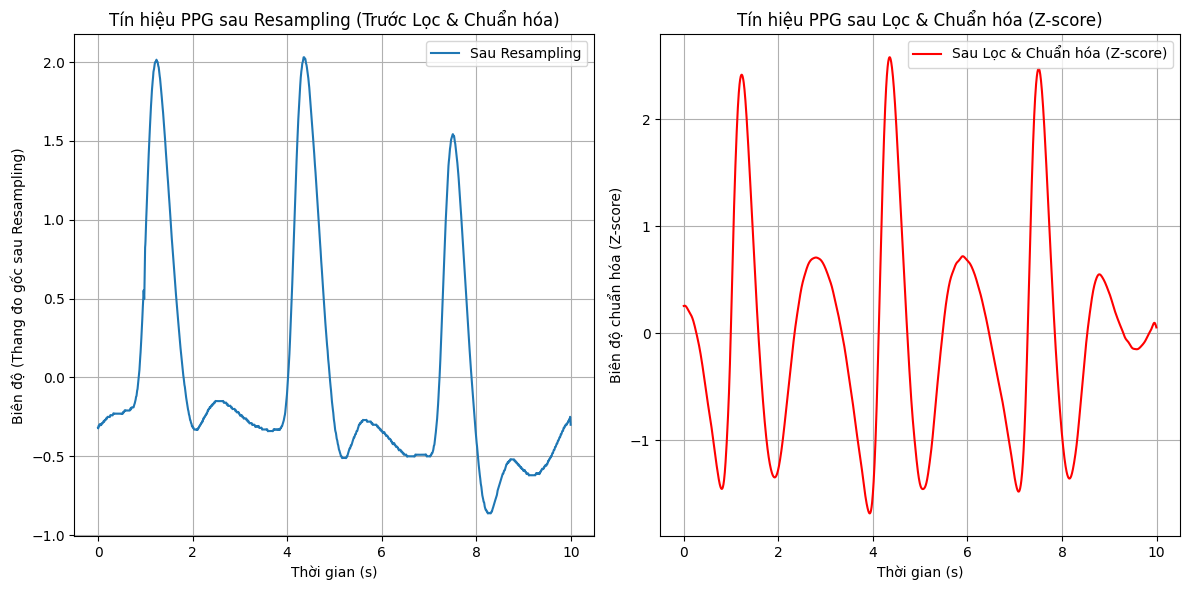

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Paths to the data files ---
# Adjust these paths if necessary
signal_before_processing_path = os.path.join(r'/kaggle/working/train_folder/', 'train_data_standardized.npz')
signal_after_processing_path = os.path.join(r'/kaggle/working/train_folder/', 'train_data_standardized_preprocessed.npz')

# --- Load one sample signal BEFORE filtering/normalization ---
try:
    data_before = np.load(signal_before_processing_path)
    # Let's take the first PPG signal segment again
    ppg_sample_before = data_before['ppg'][0]
    fs = 250 # Sampling frequency after standardization
    time_axis = np.arange(len(ppg_sample_before)) / fs
    print(f"Loaded sample BEFORE processing: Length={len(ppg_sample_before)}")

except FileNotFoundError:
    print(f"Error: Data file not found at {signal_before_processing_path}")
    ppg_sample_before = None

# --- Load the corresponding sample signal AFTER filtering/normalization ---
try:
    data_after = np.load(signal_after_processing_path)
    # Take the first PPG signal segment
    ppg_sample_after = data_after['ppg'][0]
    print(f"Loaded sample AFTER processing: Length={len(ppg_sample_after)}")

except FileNotFoundError:
    print(f"Error: Data file not found at {signal_after_processing_path}")
    ppg_sample_after = None

# --- Plotting for comparison (Figure 3.5) ---
if ppg_sample_before is not None and ppg_sample_after is not None:
    plt.figure(figsize=(12, 6))

    # Subplot 1: Signal Before Filtering/Normalization (but after resampling)
    plt.subplot(1, 2, 1)
    plt.plot(time_axis, ppg_sample_before, label='Sau Resampling')
    plt.title('Tín hiệu PPG sau Resampling (Trước Lọc & Chuẩn hóa)')
    plt.xlabel('Thời gian (s)')
    plt.ylabel('Biên độ (Thang đo gốc sau Resampling)')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Signal After Filtering/Normalization
    plt.subplot(1, 2, 2)
    plt.plot(time_axis, ppg_sample_after, label='Sau Lọc & Chuẩn hóa (Z-score)', color='red')
    plt.title('Tín hiệu PPG sau Lọc & Chuẩn hóa (Z-score)')
    plt.xlabel('Thời gian (s)')
    plt.ylabel('Biên độ chuẩn hóa (Z-score)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('figure_3_5_filtering_normalization_example.png') # Save the figure
    plt.show()
else:
    print("Could not generate plot because one or both data samples failed to load.")